Steady-state state visual evoked potentials (SSVEP) refers to periodic evoked potentials caused by rapid repetitive visual stimulation, usually at frequencies above 6Hz. It consists of multiple discrete frequency components, including the fundamental frequency of the visual stimulus and its harmonics.

**Import the require library**

pip install os<br/>
pip install mne<br/>
pip install numpy<br/>
pip install scipy<br/>
pip install matplotlib<br/>
pip install latexify-py<br/>
pip install skfeature-chappers<br/>

<br/>

In [105]:
import mne
import latexify
import warnings
import numpy as np
from importlib import reload
from Functions import Data_path, Plot_data, Filtering, FFT, Common_average_reference, PSDA_a_trial, PSDA, CCA
from Functions import FoCCA, FBCCA, MSI, FFT_Feature_Extraction, Plot_features, CCA_Feature_Extraction
from Functions import Feature_selections, Knn_optimal

**Step 1.1: Importing pathway files**

In [3]:
# Define the base folder path where the data is located
folder_path = "D:\SSVEP-based-EEG-signal-processing\Data" 
path_files, files, folders = Data_path.data_path(folder_path, data_format="gdf") 
path_files

['D:\\SSVEP-based-EEG-signal-processing\\Data\\Subject2-[2012.04.07-19.27.02].gdf',
 'D:\\SSVEP-based-EEG-signal-processing\\Data\\Subject2-[2012.04.07-19.36.29].gdf',
 'D:\\SSVEP-based-EEG-signal-processing\\Data\\Subject2-[2012.04.07-19.44.23].gdf',
 'D:\\SSVEP-based-EEG-signal-processing\\Data\\Subject2-[2012.04.07-19.57.52].gdf',
 'D:\\SSVEP-based-EEG-signal-processing\\Data\\Subject3-[2012.04.07-18.17.50].gdf',
 'D:\\SSVEP-based-EEG-signal-processing\\Data\\Subject3-[2012.04.07-18.27.18].gdf',
 'D:\\SSVEP-based-EEG-signal-processing\\Data\\Subject3-[2012.04.07-18.45.34].gdf',
 'D:\\SSVEP-based-EEG-signal-processing\\Data\\Subject3-[2012.04.07-18.53.10].gdf',
 'D:\\SSVEP-based-EEG-signal-processing\\Data\\Subject4-[2012.04.08-16.06.48].gdf',
 'D:\\SSVEP-based-EEG-signal-processing\\Data\\Subject4-[2012.04.08-16.19.25].gdf',
 'D:\\SSVEP-based-EEG-signal-processing\\Data\\Subject4-[2012.04.08-16.27.27].gdf',
 'D:\\SSVEP-based-EEG-signal-processing\\Data\\Subject4-[2012.04.08-16.35.27

**Step 1.2: Load data, channel locations, labels & events**<br/>
[Dataset](https://github.com/sylvchev/dataset-ssvep-led)<br/>
Label_01 ---> 13Hz stimulation (33025)<br/>
Label_02 ---> 21Hz stimulation (33026)<br/>
Label_03 ---> 17Hz stimulation (33027)<br/>
Rest ---> 33024

In [4]:
warnings.filterwarnings("ignore", message="Omitted .* annotation.*")
raw = mne.io.read_raw_gdf(path_files[0], verbose=0)   # Read the data from the GDF file into a raw MNE object
channels_name = raw.ch_names                          # Extract the channel names from the raw data
# Get the EEG data and transpose it to have channels as rows and samples as columns
data = 1e6 * raw.get_data().T                               
fs = raw.info['sfreq']                                # Get the sampling frequency of the EEG data
labels = raw.annotations.description                  # Define labels for each stimulation frequency
# Get the start time of each trial from the annotations
events, event_ind = mne.events_from_annotations(raw, verbose=0)

In [5]:
print(f"data: {data}, \n channels_name: {channels_name}, \n labels: {labels}, \n events: {events}, \n \
event_ind: {event_ind}")

data: [[ 0.01173966 -0.00474957 -0.01268185 ...  0.0030354   0.01228145
   0.00815642]
 [ 0.02386047  0.00503881 -0.00156107 ...  0.01227617  0.02106239
   0.01364458]
 [ 0.00539719 -0.00526715 -0.00716607 ... -0.00361855  0.00391582
   0.00301697]
 ...
 [ 0.01562747  0.01219361 -0.00798377 ...  0.00587641  0.00858811
   0.00709518]
 [-0.00210399 -0.00068503 -0.01619055 ... -0.01118462 -0.00772782
  -0.00089448]
 [-0.00248515 -0.00488658 -0.01416859 ... -0.01230607 -0.00401965
   0.00259247]], 
 channels_name: ['Oz', 'O1', 'O2', 'PO3', 'POz', 'PO7', 'PO8', 'PO4'], 
 labels: ['32769' '33024' '32779' '32780' '33026' '32779' '32780' '33027' '32779'
 '32780' '33025' '32779' '32780' '33026' '32779' '32780' '33025' '32779'
 '32780' '33024' '32779' '32780' '33027' '32779' '32780' '33025' '32779'
 '32780' '33026' '32779' '32780' '33027' '32779' '32780' '33024' '32779'
 '32780' '33026' '32779' '32780' '33024' '32779' '32780' '33027' '32779'
 '32780' '33025' '32779' '32780' '33024' '32779' '3278

**Step 2.1: Split trials for a single dataset** **(** *e.g., Subject2-[2012.04.07-19.27.02].gdf* **)**

In [6]:
time_trial = 5                          # Define the duration of each trial in seconds
time_start_trial = events[:, 0]         # Extract the start time of each trial from the events
# Calculate the duration of each trial in samples based on the sampling frequency (Fs * time each trial)
duration_trial = int(fs * time_trial)   
lab = ['33025', '33026', '33027']       # Define the labels for the current iteration

data_trials = []
for _, val in enumerate(lab):                      # Loop through the labels of interest
    num_trials = np.where(labels == val)[0] # Find the indices of trials with the current label
    # Initialize an array to store trial data for the current label
    data_trial = np.zeros((duration_trial, len(channels_name), len(num_trials))) 
    
    # Iterate over each trial index and extract the corresponding data
    for j, trial_index in enumerate(num_trials): 
        data_trial[:, :, j] = data[time_start_trial[trial_index]:time_start_trial[trial_index] + 
                                   duration_trial, :]
        
    # Using exec to dynamically create variable names for each trial's data array
    data_trials.append(data_trial) 

print(f"data_freq_13Hz: {data_trials[0].shape} \ndata_freq_21Hz: {data_trials[1].shape} \ndata_freq_17Hz:\
 {data_trials[2].shape}")

data_freq_13Hz: (1280, 8, 10) 
data_freq_21Hz: (1280, 8, 10) 
data_freq_17Hz: (1280, 8, 10)


**Step 2.2: Split trials for all datasets or stimulations**

In [7]:
time_trial = 5                          # Define the duration of each trial in seconds
data1, data2, data3 = [], [], []
lab = ['33025', '33026', '33027']       # Define the labels for the current iteration
data_list = [data1, data2, data3]       # Initialize a list to store data lists
warnings.filterwarnings("ignore", message="Omitted .* annotation.*")

for i in range(len(path_files)):
    raw = mne.io.read_raw_gdf(path_files[i], verbose=0)# Read the data from the GDF file into a raw MNE object
    fs = raw.info['sfreq']                             # Get the sampling frequency of the EEG data
    channels_name = raw.ch_names                       # Extract the channel names from the raw data
    # Calculate the duration of each trial in samples based on the sampling frequency (Fs * time each trial)
    duration_trial = int(fs * time_trial)   
    # Get the EEG data and transpose it to have channels as rows and samples as columns
    data = 10**6 * raw.get_data().T
    labels = raw.annotations.description                # Define labels for each stimulation frequency
    # Get the start time of each trial from the annotations
    events, _ = mne.events_from_annotations(raw, verbose=0) 
    time_start_trial = events[:, 0]                     # Extract the start time of each trial from the events 
    
    for j, val in enumerate(lab):                                  # Loop through the labels of interest
        num_trials = np.where(labels == val)[0]      # Find the indices of trials with the current label
        # Initialize an array to store trial data for the current label
        data_trial = np.zeros((duration_trial, len(channels_name), len(num_trials)))
        
        # Iterate over each trial index and extract the corresponding data
        for ind, trial_index in enumerate(num_trials):  
            data_trial[:, :, ind] = data[time_start_trial[trial_index]:time_start_trial[trial_index] + 
                                         duration_trial, :]
        
        # Append data_trial to the corresponding list based on the value of j
        data_list[j].append(data_trial)
        
# Concatenate the lists of data arrays along the third axis
data1 = np.concatenate(data1, axis=2)
data2 = np.concatenate(data2, axis=2)
data3 = np.concatenate(data3, axis=2)

print(f"data1.shape: {data1.shape} \ndata2.shape: {data2.shape} \ndata3.shape: {data3.shape}")

data1.shape: (1280, 8, 160) 
data2.shape: (1280, 8, 160) 
data3.shape: (1280, 8, 160)


**Step 2.3: Plot data (** *Plot a trial for one of the stimulation frequencies* **)**<br/>

*Input parameters:*
 - `data:` data1[:, :, max(0, trial - 1)]: EEG data for the specified trial (indedatang starts from 0)
 - `fs:` Sampling frequency of the EEG data
 - `channels:` Names of the EEG channels
 - `first_point:` Index of the first data point to plot (optional, defaults to 0)
 - `last_point: `Index of the last data point to plot (optional, defaults to 3000)
 - `val_ylim:` Madatamum absolute y-adatas limit for the plot (optional, defaults to 2.7)
 - `size_fig:` Size of the figure (optional, defaults to (5, 5))
 - `title:` Title of the plot (optional, defaults to 'Raw data')
 - `display_figure:` Whether to display the figure ('on' or 'off') (optional, defaults to 'on')

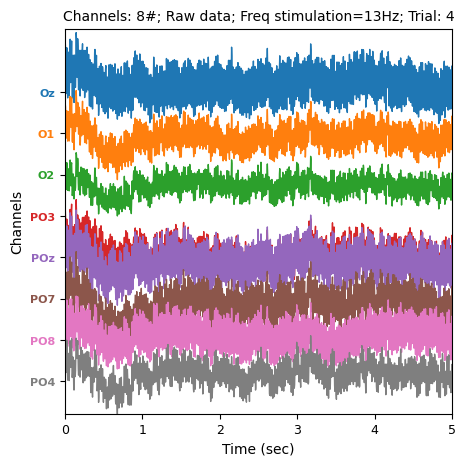

In [8]:
trial = 4          # Define trial number (trial 1 in Python index starts from 0, so trial 1 means index 0)
freq_stim = 13     # Define stimulation frequency
title = f'Raw data; Freq stimulation={freq_stim}Hz; Trial: {max(1, trial)}' # Define plot title

# Plot EEG data using the Plot_data.plot_data function
Plot_data.plot_data(data1[:, :, max(0, trial - 1)], fs, channels_name, first_point=0, last_point=1280, 
                    val_ylim=2.7, title=title, size_fig=(5, 5), display_figure="on")  

**Step 3.1: Filtering (** *Filter a trial for one of the stimulation frequencies* **)**<br/>

*Input parameters:*
 - `data:` EEG data to be filtered
 - `f_low:` Lower cutoff frequency of the bandpass filter
 - `f_high:` Upper cutoff frequency of the bandpass filter
 - `order:` Filter order
 - `fs:` Sampling frequency of the EEG data (optional, if not provided, it is assumed to be fs)
 - `type_filter:` Type of filter ('low', 'high', 'bandpass', or 'bandstop') (optional, defaults to 'bandpass')
 - `filter_active:` Filter data using a specific type of filter ('low', 'high', 'bandpass', or 'bandstop') (optional, defaults to 'on')
 - `notch_freq:` Frequency to be removed from signal (Hz)
 - `quality_factor:` Quality factor for notch filter
 - `filter_active:` Whether to activate filtering ("on" or "off")
  - `notch_filter:` Whether to apply a notch filter ("on" or "off")

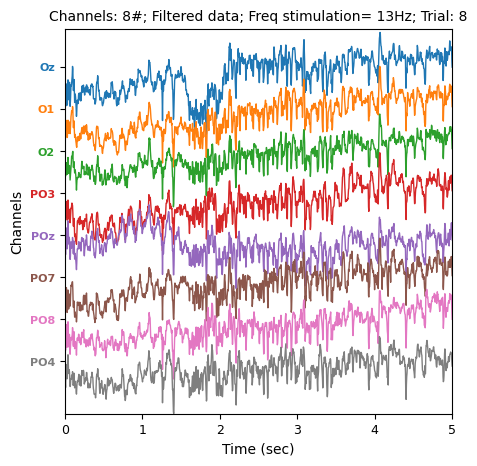

In [9]:
trial = 8            # Define trial number (trial 1 in Python index starts from 0, so trial 1 means index 0)
order = 3            # Define filter order
f_low = 0.05         # Define lower cutoff frequency for the bandpass filter (Hz)
f_high = 100         # Define upper cutoff frequency for the bandpass filter (Hz)
notch_freq = 50      # Define frequency to be removed from the signal for notch filter (Hz)
quality_factor = 20  # Define quality factor for the notch filter
notch_filter = "on"  # on or off
filter_active = "on" # on or off
design_method = "IIR" # IIR or FIR
type_filter = "bandpass"  # low, high, bandpass, or bandstop
freq_stim = 13       # Define stimulation frequency
title = f'Filtered data; Freq stimulation= {freq_stim}Hz; Trial: {max(1, trial)}' # Define plot title

# Apply bandpass filtering to the EEG data using the Filtering.filtering function
filtered_data = Filtering.filtering(data1, f_low, f_high, order, fs, notch_freq, quality_factor, filter_active,
                                    notch_filter, type_filter, design_method)
# Plot filtered EEG data using Plot_data.plot_data function
Plot_data.plot_data(filtered_data[:, :, max(0, trial - 1)], fs, channels_name, first_point=0, last_point=1280, 
                    val_ylim=2.7, title=title, size_fig=(5, 5), display_figure="on")

**Step 3.2: Fourier transform** **(** *FFT a channel for one of the stimulation frequencies* **)**

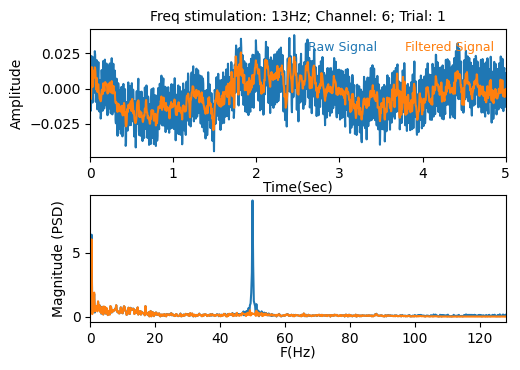

In [10]:
trial = 0          # Define trial number (trial 1 in Python index starts from 0, so trial 1 means index 0)
channel = 6        # Define channel (trial 1 in Python index starts from 0, so channel 1 means index 0)
freq_stim = 13     # Define stimulation frequency
# Define plot title
title = f"Freq stimulation: {freq_stim}Hz; Channel: {max(1, channel)}; Trial: {max(1, trial)}" 

# Perform FFT analysis on the data
FFT.fft_analysis(data1, filtered_data, fs, channel, trial, title, size_fig=[5, 3.5])

**Step 3.3: CAR filter** **(** *CAR a trial for one of the stimulation frequencies* **)**<br/>

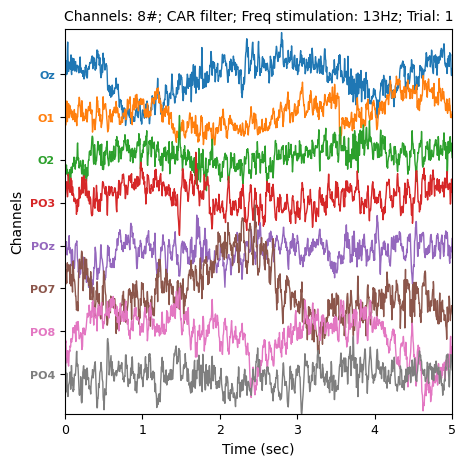

In [13]:
trial = 0          # Define trial number (trial 1 in Python index starts from 0, so trial 1 means index 0)
freq_stim = 13     # Define stimulation frequency
title = f"CAR filter; Freq stimulation: {freq_stim}Hz; Trial: {max(1, trial)}" # Define plot title

# Apply common average reference (CAR) to the EEG data using the Common_average_reference.car function
data_car = Common_average_reference.car(filtered_data, reference_channel=None) 
# Plot EEG data after applying CAR filter using Plot_data.plot_data function
Plot_data.plot_data(data_car[:, :, max(0, trial - 1)], fs, channels_name, first_point=0, last_point=1280, \
                    val_ylim=2.7, title=title, size_fig=(5, 5), display_figure="on")

**Step 4.1: Power Spectral Density Analysis (PSDA)** **(** *PSDA a channel & a trial for one of the stimulation frequencies* **)**<br/>
[Article 1](https://www.researchgate.net/profile/Javier-Castillo-27/publication/263618753_Feature_Extraction_Techniques_Based_on_Power_Spectrum_for_a_SSVEP-BCI/links/5527b5a60cf29b22c9b937bd/Feature-Extraction-Techniques-Based-on-Power-Spectrum-for-a-SSVEP-BCI.pdf)<br/>
[Article 2](https://www.researchgate.net/publication/301341524_EEG_Signal_Analysis_Methods_Based_on_Steady_State_Visual_Evoked_Potential_Stimuli_for_the_Development_of_Brain_Computer_Interfaces_A_Review_Address_for_Correspondence)<br/>
$S_k = 10 \log_{10} \left( \frac{nP(f_k)}{\sum_{m=1}^{n/2} \left[P(f + mf_{res}) + P(f - mf_{res})\right]} \right)$<br/>
where `n` is the number of points near at the frequency stimulus, `P(fk)` is the power density of the stimulus frequencies and `fres `is the resolution frequency, which depends on the number of samples used in the Fourier transform. `P(fk + mfres)` and `P(fk −mfres) `are power densities around the target frequency.

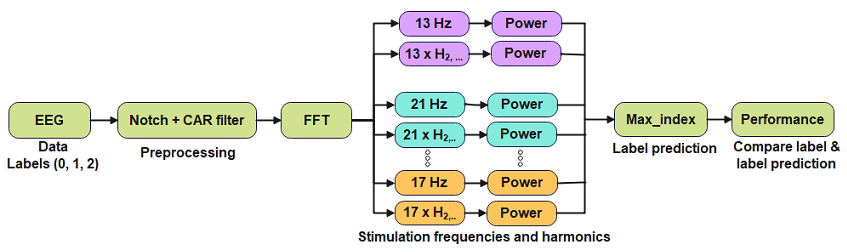

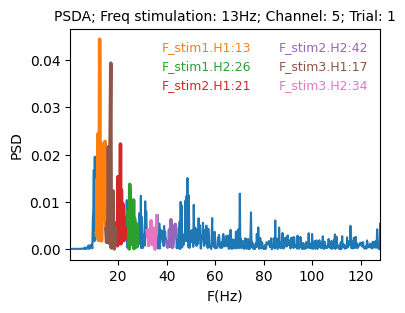

In [14]:
# ----------------------- Step 1: Filtering for one of the stimulation frequencies ---------------------------
trial = 8              # Define trial number (trial 1 in Python index starts from 0, so trial 1 means index 0)
order = 3              # Define filter order
f_low = 0.05           # Define lower cutoff frequency for the bandpass filter (Hz)
f_high = 13 - 1        # Define upper cutoff frequency for the bandpass filter (Hz) (min(f_stim) - 1)
notch_freq = 50        # Define frequency to be removed from the signal for notch filter (Hz)
quality_factor = 20    # Define quality factor for the notch filter
notch_filter = "on"    # on or off
filter_active = "on"   # on or off
design_method = "IIR" # IIR or FIR
type_filter = "high"   # low, high, bandpass, or bandstop

# Apply high filtering to the EEG data using the Filtering.filtering function
filtered_data = Filtering.filtering(data1, f_low, f_high, order, fs, notch_freq, quality_factor, filter_active,
                                    notch_filter, type_filter, design_method)
# --------------------------- Step 2: CAR for one of the stimulation frequencies------------------------------
data_car = Common_average_reference.car(filtered_data)
# ------------------------- Step 3: PSDA for one of the stimulation frequencies-------------------------------
trial = 0              # Define trial number (trial 1 in Python index starts from 0, so trial 1 means index 0)
channel = 5            # Define channel (trial 1 in Python index starts from 0, so channel 1 means index 0)
freq_stim = 13         # Define stimulation frequency
num_harmonic = 2       # Number of harmonic for each frequency stimulation
num_sample_neigh = 20  # Number of samples neighborhood for each frequency stimulation
f_stim = [13, 21, 17]  # Frequencies stimulation
# Define plot title
title = f"PSDA; Freq stimulation: {freq_stim}Hz; Channel: {max(1, channel)}; Trial: {max(1, trial)}" 

# Perform PSDA analysis for one of the stimulation frequencies
max_freq, label = PSDA_a_trial.psda_a_trial(data_car[:, max(0, channel - 1), max(0, trial - 1)], fs, 
                                            num_sample_neigh, f_stim, num_harmonic, title, fig_size=[4, 3])

**Step 4.2: Power Spectral Density Analysis (PSDA) for all datasets or stimulations**<br/>

In [15]:
# ----------------------------------- Step 1: Combine all of datasets ----------------------------------------
data_total = np.concatenate((data1, data2, data3), axis=2)
labels = np.concatenate((np.full(data1.shape[-1], 0), np.full(data2.shape[-1], 1), np.full(data3.shape[-1], 2)))
# -------------------------------- Step 2: Filtering for all of datasets -------------------------------------
order = 3                # Define filter order
f_low = 0.05             # Define lower cutoff frequency for the bandpass filter (Hz)
f_high = 100             # Define upper cutoff frequency for the bandpass filter (Hz)
notch_freq = 50          # Define frequency to be removed from the signal for notch filter (Hz)
quality_factor = 20      # Define quality factor for the notch filter
notch_filter = "on"      # on or off
filter_active = "off"    # on or off
type_filter = "bandpass" # low, high, bandpass, or bandstop

# Apply notch filter to the EEG data using the Filtering.filtering function
filtered_data = Filtering.filtering(data_total, f_low, f_high, order, fs, notch_freq, quality_factor, 
                                    filter_active, notch_filter, type_filter)
# ------------------------------------- Step 3: CAR for all of datasets --------------------------------------
data_car = Common_average_reference.car(filtered_data) 
# ---------------------------------- Step 4: PSDA for all of datasets ----------------------------------------
num_channel = [0, 1, 2]   # Number of Channel
num_harmonic = 2          # Number of harmonic for each frequency stimulation
num_sample_neigh = 30     # Number of samples neighborhood for each frequency stimulation
f_stim = [13, 21, 17]     # Frequencies stimulation

# Perform psda analysis for multiple channels
predict_label = PSDA.psda_analysis(data_car[:, num_channel], f_stim, num_sample_neigh, fs, num_harmonic)
# Calculate and print accuracy
print(f"Accuracy: {np.sum(labels == predict_label) / len(predict_label) * 100:.2f}") 

Accuracy: 94.79


**Step 5.1: Canonical correlation analysis (CCA) Method**<br/>
[Article 1](https://graphics.stanford.edu/courses/cs233-18-spring/ReferencedPapers/CCA_Weenik.pdf)<br/>
[Article 2](https://ieeexplore.ieee.org/abstract/document/4015614)<br/>
[Article 3](https://www.frontiersin.org/articles/10.3389/fninf.2016.00049/full)<br/>
CCA is a statistical technique used to find correlations between two sets of data (EEG signals from different channels and sinusoidal signals at the stimulation frequencies and their harmonics). It aims to identify the linear relationships between variables in each set and determine the maximum correlation between linear combinations of variables from the two sets.<br/>
Given two multidimensional variables $X \in \mathbb{R}^{m \times k}$ and $Z \in \mathbb{R}^{n \times k}$, CCA seeks a pair of weight vectors $w \in \mathbb{R}^{m \times 1}$ and $v \in \mathbb{R}^{n \times 1}$, to maximize the correlation between $x = w^TX$ and $z = v^TZ$. The optimization problem is expressed below.<br/>
$\rho = \underset{w, v}{\text{arg max}} \frac{E[xz^T]}{\sqrt{E[xx^T] E[zz^T]}} = \underset{w, v}{\text{arg max}} \frac{w^T XZ^T v}{\sqrt{w^T XX^T w w^T ZZ^T v}}$<br/>
The formula can be maximized by solving a generalized eigenvalue problem.<br/>
*`D`* be the minimal rank of $X$ and $Y_{i}$. *`D`* correlation coefficients, i.e., $\rho_1, \rho_2, \ldots, \rho_D$, for $X$ and $Y_{i}$, $i = 1, 2, \ldots, N_f$.<br/>
$\lambda = max(\rho_1, \rho_2, \ldots, \rho_D)$


`CCA step by step:`
- Step 1: Generate sine and cosine waves for the fundamental and harmonic frequencies for each stimulus frequency to create the reference signal set Y.
- Step 2: Calculate the covariance matrices (EEG & Yref) 
- Step 3: Perform singular value decomposition on the covariance matrices or the data sets.
- Step 4: Obtain the singular values and singular vectors from the decomposition.
- Step 5: Calculate the canonical correlation coefficients using the singular values.
- Step 6: Interpret the canonical correlation coefficients to understand the relationships between the variables in each set.

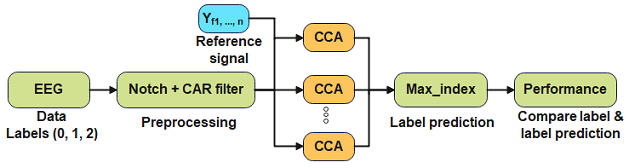

In [16]:
# ---------------------------------- Step 1: Combine all of datasets -----------------------------------------
data_total = np.concatenate((data1, data2, data3), axis=2)
labels = np.concatenate((np.full(data1.shape[-1], 0), np.full(data2.shape[-1], 1), np.full(data3.shape[-1], 2)))
# ----------------------- Step 1: Filtering for one of the stimulation frequencies ---------------------------
order = 4                # Define filter order
f_low = 0.05             # Define lower cutoff frequency for the bandpass filter (Hz)
f_high = 100             # Define upper cutoff frequency for the bandpass filter (Hz)
notch_freq = 50          # Define frequency to be removed from the signal for notch filter (Hz)
quality_factor = 20      # Define quality factor for the notch filter
notch_filter = "on"      # on or off
filter_active = "off"    # on or off
type_filter = "bandpass" # low, high, bandpass, or bandstop

# Apply notch filter to the EEG data using the Filtering.filtering function
filtered_data = Filtering.filtering(data_total, f_low, f_high, order, fs, notch_freq, quality_factor, 
                                    filter_active, notch_filter, type_filter)
# -------------------------- Step 2: CAR for one of the stimulation frequencies-------------------------------
data_car = Common_average_reference.car(filtered_data)
# ----------------------------------------- Step 3: CCA Method -----------------------------------------------
num_harmonic = 4          # Number of harmonic for each frequency stimulation
f_stim = [13, 21, 17]     # Frequencies stimulation
num_channel = [0, 1, 2]   # Number of Channel

# Perform cca analysis for multiple channels
predict_label = CCA.cca(data_car, fs, f_stim, num_channel, num_harmonic)
print(f"Accuracy: {np.sum(labels == predict_label) / len(predict_label) * 100:.2f}")

Accuracy: 92.08


**Step 5.2: Fusing Canonical Coefficients (FoCCA) method**<br/>
[Article](https://ieeexplore.ieee.org/document/8692441)<br/>
FoCCA combines correlation coefficients from CCA using a nonlinear weighting function for frequency recognition. Its goal is to enhance classification accuracy and information transfer rate compared to the standard CCA method. FoCCA retains discriminative information by combining all the correlation coefficients of CCA using a nonlinear weighting function, which may be lost in standard CCA.<br/>
$\eta = \sum_{k=0}^{D} \phi_k \cdot (\lambda_k)^2$<br/> 
$\phi_k = k^{-a} + b, \quad k = 1, 2, \ldots, D$<br/> 
$\boldsymbol{\phi} = [\phi_1 \phi_2 \ldots \phi_D]^T$<br/>
$\lambda = [\lambda_1 \lambda_2 \ldots \lambda_D]^T$<br/>
$D$ canonical coefficients in descending order, e.g. $\lambda_1 \geq \lambda_2 \geq \ldots \geq \lambda_D$.<br/>
$f = \max_i \, \eta(f_i)\quad\quad i = 1, 2, \ldots, N_f$<br/>

`CCA step by step:`
- Step 1: calculate the canonical coefficients using standard CCA for a test sample and the reference signal at each stimulus frequency.
- Step 2: A weighted summation method is used to combine the $D$ coefficients obtained from the CCA, with the weights denoted as "$\phi$" and the coefficients arranged in descending order.
- Step 3: The combined coefficients are used as the new feature for classification in the frequency recognition process.

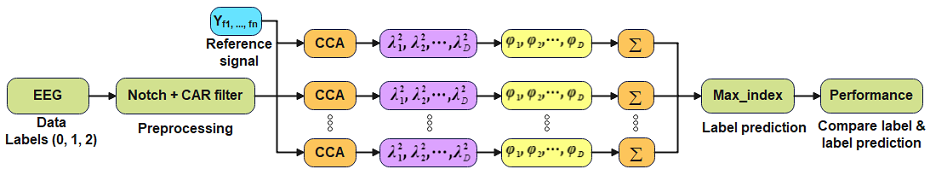

In [16]:
# ---------------------------------- Step 1: Combine all of datasets -----------------------------------------
data_total = np.concatenate((data1, data2, data3), axis=2)
labels = np.concatenate((np.full(data1.shape[-1], 0), np.full(data2.shape[-1], 1), np.full(data3.shape[-1], 2)))
# ---------------------- Step 1: Filtering for one of the stimulation frequencies ----------------------------
order = 4                # Define filter order
f_low = 0.05             # Define lower cutoff frequency for the bandpass filter (Hz)
f_high = 100             # Define upper cutoff frequency for the bandpass filter (Hz)
notch_freq = 50          # Define frequency to be removed from the signal for notch filter (Hz)
quality_factor = 20      # Define quality factor for the notch filter
notch_filter = "on"      # on or off
filter_active = "off"    # on or off
type_filter = "bandpass" # low, high, bandpass, or bandstop

# Apply notch filter to the EEG data using the Filtering.filtering function
filtered_data = Filtering.filtering(data_total, f_low, f_high, order, fs, notch_freq, quality_factor, 
                                    filter_active, notch_filter, type_filter)
# --------------------------- Step 2: CAR for one of the stimulation frequencies------------------------------
data_car = Common_average_reference.car(filtered_data)
# ------------------------------------------- Step 3: CCA Method ---------------------------------------------
num_harmonic = 2          # Number of harmonic for each frequency stimulation
f_stim = [13, 21, 17]     # Frequencies stimulation
num_channel = [0, 1, 2]   # Number of Channel          
a = [0.01, 0.1, 0, 3, 5]
b = [0.01, 0.1, 0, 1, 10]

# Perform focca analysis for multiple channels
accuracy = FoCCA.focca_analysis(data_car, labels, fs, f_stim, num_channel, num_harmonic, a, b)

0.01, 0.01 --> 94.17
0.01, 0.1 --> 94.17
0.01, 0 --> 94.17
0.01, 1 --> 94.17
0.01, 10 --> 94.17
0.1, 0.01 --> 94.17
0.1, 0.1 --> 94.17
0.1, 0 --> 94.17
0.1, 1 --> 94.17
0.1, 10 --> 94.17
0, 0.01 --> 94.17
0, 0.1 --> 94.17
0, 0 --> 94.17
0, 1 --> 94.17
0, 10 --> 94.17
3, 0.01 --> 93.54
3, 0.1 --> 93.75
3, 0 --> 93.54
3, 1 --> 94.17
3, 10 --> 94.17
5, 0.01 --> 93.54
5, 0.1 --> 93.54
5, 0 --> 93.54
5, 1 --> 93.96
5, 10 --> 94.17


**Step 5.3: Filter bank canonical correlation analysis (FBCCA) method**<br/>
[Article](https://iopscience.iop.org/article/10.1088/1741-2560/12/4/046008/ampdf)<br/>
FBCCA combines fundamental and harmonic frequency components to improve SSVEP detection by dividing the SSVEP signals into subbands with varying frequency ranges.

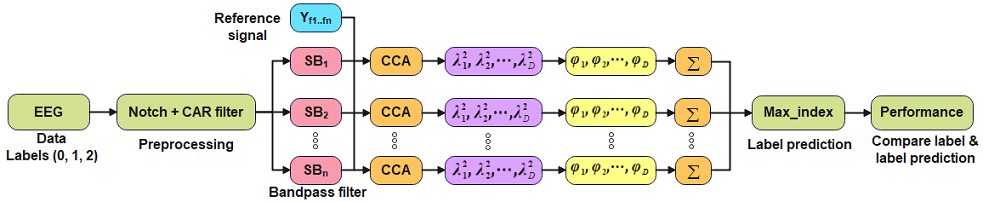

In [20]:
# ---------------------------------- Step 1: Combine all of datasets -----------------------------------------
data_total = np.concatenate((data1, data2, data3), axis=2)
labels = np.concatenate((np.full(data1.shape[-1], 0), np.full(data2.shape[-1], 1), np.full(data3.shape[-1], 2)))
# ---------------------- Step 1: Filtering for one of the stimulation frequencies ----------------------------
order = 4                # Define filter order
f_low = 0.05             # Define lower cutoff frequency for the bandpass filter (Hz)
f_high = 100             # Define upper cutoff frequency for the bandpass filter (Hz)
notch_freq = 50          # Define frequency to be removed from the signal for notch filter (Hz)
quality_factor = 20      # Define quality factor for the notch filter
notch_filter = "on"      # on or off
filter_active = "off"    # on or off
type_filter = "bandpass" # low, high, bandpass, or bandstop

# Apply notch filter to the EEG data using the Filtering.filtering function
filtered_data = Filtering.filtering(data_total, f_low, f_high, order, fs, notch_freq, quality_factor, 
                                    filter_active, notch_filter, type_filter)
# -------------------------- Step 2: CAR for one of the stimulation frequencies-------------------------------
data_car = Common_average_reference.car(filtered_data)
# ------------------------------------------ Step 3: FBCCA Method --------------------------------------------
method = 'm3'             # Type filter banks: M1, M2, M3
num_harmonic = 2          # Number of harmonic for each frequency stimulation
notch_filter = "off"      # on or off
filter_active = "on"      # on or off
type_filter = "bandpass"  # low, high, bandpass, or bandstop
f_stim = [13, 21, 17]     # Frequencies stimulation
num_channel = [0, 1]   # Number of Channel          
a = [0.01, 0]
b = [0.001, 0]
filter_banks = [[10,  20,  30,  40,  50,  60,  70,  80,  90],
 [100, 100, 100, 100, 100, 100, 100, 100, 100]]

# Perform fbcca analysis for multiple channels
FBCCA.fbcca_analysis(data_car, labels, fs, f_stim, num_channel, num_harmonic, a, b, filter_banks, order, 
                     notch_freq, quality_factor, filter_active, notch_filter, type_filter)

0.01, 0.001 --> 97.71
0.01, 0 --> 97.71
0, 0.001 --> 97.71
0, 0 --> 97.71


['97.71', '97.71', '97.71', '97.71']

**Step 5.4: Multivariate synchronization index (MSI) method**<br/>
[Article](https://www.sciencedirect.com/science/article/abs/pii/S0165027013002677)<br/>
The MSI method estimates synchronization between mixed signals and reference signals for frequency recognition. It utilizes the S-estimator, based on the entropy of normalized eigenvalues of the correlation matrix of multivariate signals.

$c = \begin{bmatrix} c_{11} & c_{12} \\ c_{21} & c_{22} \end{bmatrix} \quad  c_{11} = \frac{1}{m}xx^T  \quad  c_{22} = \frac{1}{m} yy^T \quad c_{12} = c_{21} = \frac{1}{m} xy^T$

$u = \begin{bmatrix} c_{11}^{(-1/2)} & 0 \\ 0 & c_{22}^{(-1/2)} \end{bmatrix} \quad R = ucu^T = \begin{bmatrix} I_{n \times n} & c_{11}^{(-1/2)} c_{12} c_{22}^{(-1/2)} \\ c_{22}^{(-1/2)} c_{21} c_{11}^{(-1/2)} & I_{2n_h \times 2n_h} \end{bmatrix}$

$\lambda_i = \frac{\lambda_i}{\sum_{i=1}^{p} \lambda_i} = \frac{\lambda_i}{\text{tr}(R)}\quad \quad s = 1 + \frac{\sum_{i=1}^{p} \lambda_i \log(\lambda_i)}{\log(p)}$

$x: n × m \quad  y: 2n_{h} × m$<br/>
*`n`* is the number of channels, *`m`* is the number of samples, and *`nh`* is the number of harmonics for the sine and cosine components.




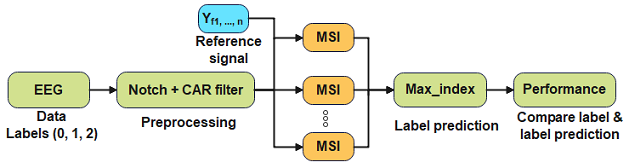

In [36]:
# ---------------------------------- Step 1: Combine all of datasets -----------------------------------------
data_total = np.concatenate((data1, data2, data3), axis=2)
labels = np.concatenate((np.full(data1.shape[-1], 0), np.full(data2.shape[-1], 1), np.full(data3.shape[-1], 2)))
# ---------------------- Step 1: Filtering for one of the stimulation frequencies ----------------------------
order = 4                # Define filter order
f_low = 0.05             # Define lower cutoff frequency for the bandpass filter (Hz)
f_high = 100             # Define upper cutoff frequency for the bandpass filter (Hz)
notch_freq = 50          # Define frequency to be removed from the signal for notch filter (Hz)
quality_factor = 20      # Define quality factor for the notch filter
notch_filter = "on"      # on or off
filter_active = "off"    # on or off
type_filter = "bandpass" # low, high, bandpass, or bandstop

# Apply notch filter to the EEG data using the Filtering.filtering function
filtered_data = Filtering.filtering(data_total, f_low, f_high, order, fs, notch_freq, quality_factor, 
                                    filter_active, notch_filter, type_filter)
# -------------------------- Step 2: CAR for one of the stimulation frequencies-------------------------------
data_car = Common_average_reference.car(filtered_data)
# ------------------------------------------ Step 3: MSI Method ----------------------------------------------
num_harmonic = 2          # Number of harmonic for each frequency stimulation
f_stim = [13, 21, 17]     # Frequencies stimulation
num_channel = [0, 1]      # Number of Channel          

# Perform msi analysis for multiple channels
predict_label = MSI.msi(data_car, fs, f_stim, num_channel, num_harmonic)
print(f"Accuracy: {np.sum(labels == predict_label) / len(predict_label) * 100:.3f}")

Accuracy: 90.625


**Step 6.1: Feature Extraction using FFT**

![FFT feature extraction.png](<attachment:FFT feature extraction.png>)
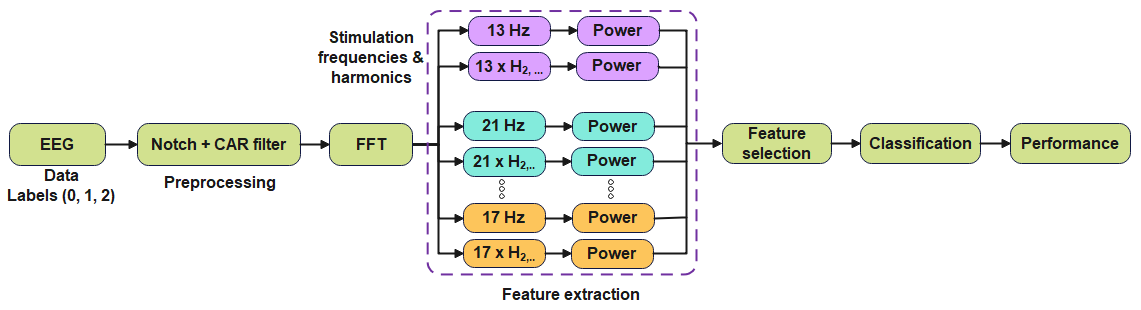

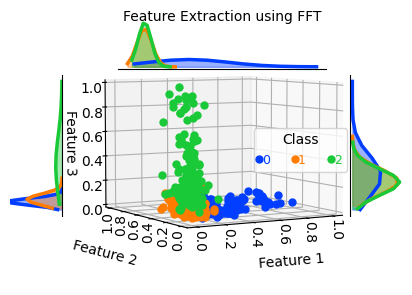

In [47]:
# ----------------------------------- Step 1: Combine all of datasets ----------------------------------------
data_total = np.concatenate((data1, data2, data3), axis=2)
labels = np.concatenate((np.full(data1.shape[-1], 0), np.full(data2.shape[-1], 1), np.full(data3.shape[-1], 2)))
# -------------------------------- Step 2: Filtering for all of datasets -------------------------------------
order = 3                # Define filter order
notch_freq = 50          # Define frequency to be removed from the signal for notch filter (Hz)
quality_factor = 20      # Define quality factor for the notch filter
subbands = [[12, 16, 20],
            [14, 18, 22]]
f_low = np.min(subbands) - 1  # Define lower cutoff frequency for the bandpass filter (Hz)
f_high = np.max(subbands) + 1 # Define upper cutoff frequency for the bandpass filter (Hz)
notch_filter = "on"       # on or off
filter_active = "on"      # on or off
type_filter = "bandpass"  # low, high, bandpass, or bandstop
# Apply notch filter to the EEG data using the Filtering.filtering function
filtered_data = Filtering.filtering(data_total, f_low, f_high, order, fs, notch_freq, quality_factor, 
                                    filter_active, notch_filter, type_filter)
# ------------------------------------- Step 3: CAR for all of datasets --------------------------------------
data_car = Common_average_reference.car(filtered_data) 
# ---------------------------------- Step 4: Feature Extraction using FFT ------------------------------------
num_channel = [0, 1]   # Number of Channel
title = f"Feature Extraction using FFT"

# Perform fft_feature_extraction analysis for multiple channels
features = FFT_Feature_Extraction.fft_feature_extraction(data_car, fs, num_channel, subbands)
Plot_features.plot_features(features, labels, title, location_legend=5)

**Step 6.2: Feature Extraction using CCA**

![CCA feature extraction-2.png](<attachment:CCA feature extraction-2.png>)
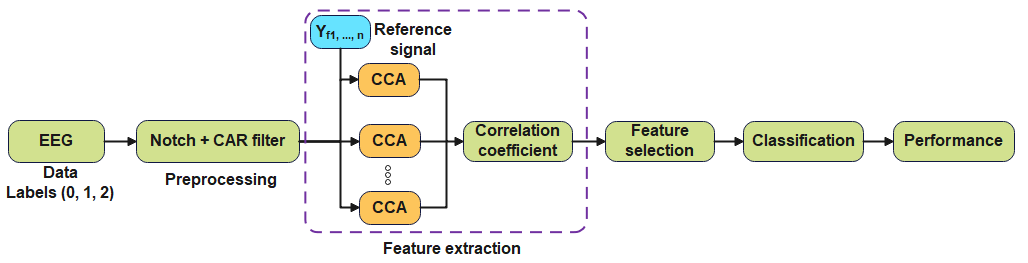
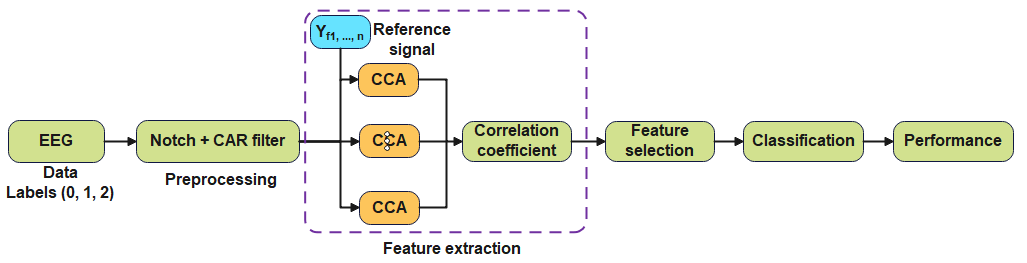

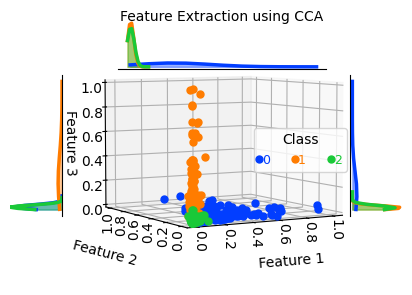

In [17]:
# ----------------------------------- Step 1: Combine all of datasets ----------------------------------------
data_total = np.concatenate((data1, data2, data3), axis=2)
labels = np.concatenate((np.full(data1.shape[-1], 0), np.full(data2.shape[-1], 1), np.full(data3.shape[-1], 2)))
# -------------------------------- Step 2: Filtering for all of datasets -------------------------------------
order = 3                # Define filter order
notch_freq = 50          # Define frequency to be removed from the signal for notch filter (Hz)
quality_factor = 20      # Define quality factor for the notch filter
subbands = [[12, 16, 20],
            [14, 18, 22]]
f_low = np.min(subbands) - 1  # Define lower cutoff frequency for the bandpass filter (Hz)
f_high = np.max(subbands) + 1 # Define upper cutoff frequency for the bandpass filter (Hz)
notch_filter = "on"       # on or off
filter_active = "on"      # on or off
type_filter = "bandpass"  # low, high, bandpass, or bandstop
# Apply notch filter to the EEG data using the Filtering.filtering function
filtered_data = Filtering.filtering(data_total, f_low, f_high, order, fs, notch_freq, quality_factor, 
                                    filter_active, notch_filter, type_filter)
# ------------------------------------- Step 3: CAR for all of datasets --------------------------------------
data_car = Common_average_reference.car(filtered_data) 
# ---------------------------------- Step 4: Feature Extraction using CCA ------------------------------------
num_harmonic = 2          # Number of harmonic for each frequency stimulation
f_stim = [13, 21, 17]     # Frequencies stimulation
num_channel = [0, 1]      # Number of Channel     
title = f"Feature Extraction using CCA"

# Perform cca_feature_extraction analysis for multiple channels
features_extraction = CCA_Feature_Extraction.cca_feature_extraction(data_car, fs, f_stim, num_channel, num_harmonic)
Plot_features.plot_features(features_extraction, labels, title, location_legend=5)

**Step 7: Feature Selection**

- Filter Methods
  - ANOVA
  - Variance (Var)
  - Fisher_score (FS)
  - Mutual information (MI); `n_neighbors_MI `
  - Univariate feature selection (UFS)
- Wrapper Methods
  - Forward feature selection (FFS)
  - Backward feature selection (BFS)
  - Exhaustive Feature Selection (EFS)
  - Recursive feature elimination (RFE)
- Embedded Methods
  - Random forest (RF)
  - L1-based feature selection (L1); `L1_Parameter `
  - Tree-based feature selection (TFS)

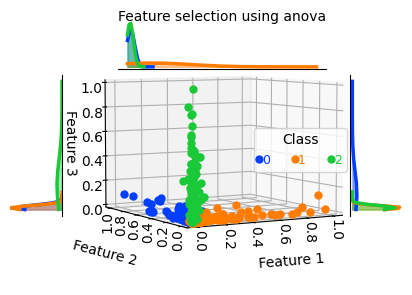

In [18]:
num_features = 4
n_neighbors_MI = 5                 # Number of neighbors to consider for mutual information calculation.
L1_Parameter = 0.1                 # Parameter value for L1 regularization.
threshold_var = 0.001              # The threshold used for variance thresholding.
type_feature_selection = "anova"   # var, anova, mi, ufs, rfe, rf, l1fs, tfs, fs, ffs, bfs
title = f"Feature selection using {type_feature_selection}"

features = Feature_selections.feature_selecions(features_extraction, labels, num_features,threshold_var,
                                                         n_neighbors_MI, L1_Parameter, type_feature_selection)
Plot_features.plot_features(features, labels, title, location_legend=5, fig_size=(4, 3))

**Step 8: Classification methods**

In [146]:

# ------------------------------------------------------ MLP --------------------------------------------
MLP = "on"
epochs = 2 
batch_size = 8
optimizer = "adam"
learning_rate = 0.01
validation_split = 0.2
# -------------------------------------------------------- CNN ------------------------------------------
CNN = "off"
optimizer_cnn = "adam"
learning_rat_cnn = 0.01
epochs_cnn = 2 
batch_size_cnn = 8
# ------------------------------------------------------ SVM --------------------------------------------
SVM = "off"
C_SVM = 10
criterion = "gini"                               # gini, entropy, log_loss for DT and RF
kernel_SVM ="rbf"                                # 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'
# ------------------------------------------------------ AdaBoost --------------------------------------------
AdaBoost = "off"
lr_AdaBoost = 0.1
# ------------------------------------------------------ XGBoost --------------------------------------------
XGBoost = "off"
lr_XGBoost = 0.1
# ------------------------------------------------------ LDA --------------------------------------------
solver_LDA = "svd"                               # svd, lsqr, eigen
n_estimators = 300                               # N_estimators for RF, AdaBoost, XGBoost
max_depth = 3                                    # Max_depth for DT, RF, XGBoost


In [154]:
# ------------------------------------------------------ LR --------------------------------------------
LR = "off"
max_iter = 1000                                  # Max_iter for LR
solver_LR = 'lbfgs'                              # Solver for LR lbfgs, liblinear, newton-cg, newton-cholesky, sag, saga; for 

DT = "off"
NB = "off"
RF = "off"
LDA = "off"
KNN = "off"

k_fold = 3

method = "MinMaxScaler"                          # MinMaxScaler" , StandardScaler for data normalization 
normalize_active = "on"                          # normalize_active for data normalization

display_fold_classification = 2                  # Plot train and test data in k_fold eg., 1
display_classification = "off"                   # Display train and test data in k_fold eg., 1
display_normalize_classification ="off"          # Display train and test data is normalized

display_Roc_classes = "off"                      # Display Roc curve for all classes in each k-fold
display_all_kfold = "off"                        # Display Roc curve for each k-fold only
display_Roc_classification = "of"               # Display the average Roc curve of all k-folds for each classification

display_optimal_k = "off"                        # Display k optimal neighbors for KNN

display_performance_sessions = "off"
display_performance_all_sessions = "off"
fig_size_Roc = (7, 3)
fig_size_classification = (5, 3)
fig_size_performance = (7, 3.5) 

# fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7, 3), sharey="row", constrained_layout=True)


classification_methods(features, labels, k_fold, max_iter, solver_LR, kernel_SVM, C_SVM, criterion, lr_AdaBoost, lr_XGBoost, n_estimators, 
                       max_depth, solver_LDA, LR, MLP, SVM, DT, NB, RF, AdaBoost, XGBoost, LDA, KNN,  normalize_active, method, 
                       display_fold_classification, display_classification, display_normalize_classification, display_Roc_classes, 
                       display_all_kfold, display_Roc_classification, fig_size_Roc, fig_size_classification, fig_size_performance, 
                       display_optimal_k, optimizer, learning_rate, epochs, batch_size, validation_split, optimizer_cnn, 
                       learning_rat_cnn, epochs_cnn, batch_size_cnn, CNN)


Epoch 1/2
32/32 [==============================] - 9s 98ms/step - loss: 1.0356 - accuracy: 0.5742 - auc_43: 0.7944 - precision_43: 1.0000 - recall_43: 0.0156 - f1_score: 0.4539 - val_loss: 1.1354 - val_accuracy: 0.2500 - val_auc_43: 0.3344 - val_precision_43: 0.0000e+00 - val_recall_43: 0.0000e+00 - val_f1_score: 0.1333
Epoch 2/2
5/5 [==============================] - 1s 14ms/step - loss: 0.6824 - accuracy: 0.7625 - auc_43: 0.9146 - precision_43: 1.0000 - recall_43: 0.5063 - f1_score: 0.7317
Epoch 1/2
32/32 [==============================] - 7s 68ms/step - loss: 1.0306 - accuracy: 0.7148 - auc_44: 0.8661 - precision_44: 1.0000 - recall_44: 0.0039 - f1_score: 0.5568 - val_loss: 1.1210 - val_accuracy: 0.1406 - val_auc_44: 0.4243 - val_precision_44: 0.0000e+00 - val_recall_44: 0.0000e+00 - val_f1_score: 0.0822
Epoch 2/2
5/5 [==============================] - 1s 39ms/step - loss: 0.9380 - accuracy: 0.4750 - auc_44: 0.7535 - precision_44: 0.5982 - recall_44: 0.4187 - f1_score: 0.3913
Epoch 

In [149]:
def mlp(data_train, label_train, data_test, label_test, optimizer, learning_rate, epochs, batch_size, validation_split):
   
    num_classes = len(np.unique(label_train))
    label_train = to_categorical(label_train)

    model = tf.keras.Sequential([              # Define the model architecture
        tf.keras.layers.Dense(128, activation='relu', input_shape=(data_train.shape[1],)),
        # tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        # tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, activation='relu'),
        # tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')])

    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate) # Compile the model with SGD optimizer and a learning rate 
    elif optimizer == "adam":
        optimizer = keras.optimizers.Adam(amsgrad=True, learning_rate=learning_rate)
        
    model.compile(optimizer="adam", 
                loss='categorical_crossentropy', 
                metrics=['accuracy',  # Continue to track accuracy as well.
                keras.metrics.AUC(), 
                keras.metrics.Precision(),
                keras.metrics.Recall(),
                keras.metrics.F1Score(average=None, threshold=None, name='f1_score', dtype=None)])

    model.fit(data_train, label_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=1) # Train the model with a batch size of 8

    return model
 
def mlp_test(data, labels, k_fold, optimizer, learning_rate, epochs, batch_size, validation_split, normalize_active, method):
   # -------------------------------------------------------- K_fold --------------------------------------------------------------
      cv = model_selection.StratifiedKFold(n_splits=k_fold)     
      accuracy_tr, accuracy_te, f1_tr, f1_te, precision_tr, precision_te, recall_tr, recall_te, type_method = [], [], [], [], [], [], [], [], []
   # -------------------------------------------------------- Parameters ----------------------------------------------------------
      for j, (train, test) in enumerate(cv.split(data, labels)):  
         # --------------------------------------------------- Split data ------------------------------------------------------------
         data_train = data[train] 
         data_test = data[test]
         label_train = labels[train]
         label_test = labels[test]
         # -------------------------------------------------- Data normalization -----------------------------------------------------
         if normalize_active == "on": 
             data_train, data_test = data_normalization(data_train, data_test, method=method)   # method 1: MinMaxScaler, method 2: StandardScaler
         # ------------------------------------------------------ KNN methods --------------------------------------------------------
         model = mlp(data_train, label_train, data_test, label_test, optimizer, learning_rate, epochs, batch_size, validation_split)
         loss, acc, auc, pre, rec, f1  =  model.evaluate(data_test, to_categorical(label_test), verbose=1) # Evaluate the model on the test set
         # ---------------------------------------------- Training Section -----------------------------------------------------------
         # accuracy_tr.append(0) # Calculate accuracy  
         # f1_tr.append(0) # Calculate F1 score
         # precision_tr.append(0)  # Calculate precision
         # recall_tr.append(0)   # Calculate recall
         # ----------------------------------------------- Test Section --------------------------------------------------------------
         accuracy_te.append(acc) # Calculate accuracy  
         f1_te.append(np.mean(f1))# Calculate F1 score
         precision_te.append(pre)  # Calculate precision
         recall_te.append(rec)   # Calculate recall
      
      return accuracy_te, precision_te, recall_te, f1_te, "MLP"

In [93]:
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn import model_selection, metrics, neural_network, tree, naive_bayes, discriminant_analysis, neighbors
from sklearn import preprocessing, svm, ensemble, linear_model
from tensorflow.keras.utils import to_categorical  # Convert labels to categorical (one-hot encoding)
import tensorflow as tf
from tensorflow import keras

In [130]:
from Functions import ROC

In [152]:
# ============================================== Classification methods ================================================== 
def classification_methods(data, labels, k_fold, max_iter, solver_LR, kernel_SVM, C_SVM, criterion, lr_AdaBoost, 
                           lr_XGBoost, n_estimators, max_depth, solver_LDA, LR, MLP, SVM, DT, NB, RF, AdaBoost, XGBoost, LDA, KNN,
                           normalize_active, method, display_fold_classification, display_classification, display_normalize_classification, 
                           display_Roc_classes, display_all_kfold, display_Roc_classification, fig_size_Roc, fig_size_classification, 
                           fig_size_performance, display_optimal_k, optimizer, learning_rate, epochs, batch_size, validation_split,
                           optimizer_cnn, learning_rat_cnn, epochs_cnn, batch_size_cnn, CNN):
                           
   accuracy_tr, accuracy_te, f1_tr, f1_te, precision_tr, precision_te, recall_tr, recall_te, type_method = [], [], [], [], [], [], [], [], []

   if display_Roc_classification == "on":
      fig, axs = plt.subplots(nrows=1, ncols=2, figsize=fig_size_Roc, constrained_layout=True)
   else:
      fig, axs = [], []
   # ------------------------------------------------------ Logistic Regression -------------------------------------------------------
   if LR == "on":
      model = linear_model.LogisticRegression(C=1, max_iter=max_iter, solver=solver_LR, penalty='l2', multi_class="multinomial", verbose=0)
      
      output = classification(model, data, labels, fig, axs, k_fold, normalize_active, method, display_fold_classification, display_classification, 
                              display_normalize_classification, display_Roc_classes, display_all_kfold, display_Roc_classification, fig_size_Roc, 
                              fig_size_classification, display_optimal_k, type_class="LR")

      accuracy_tr.append(output[0]), accuracy_te.append(output[1]), f1_tr.append(output[2]), f1_te.append(output[3]), 
      precision_tr.append(output[4]), precision_te.append(output[5]), recall_tr.append(output[6]), recall_te.append(output[7]),
      type_method.append(output[8]),

   # ----------------------------------------------------------- MLP ------------------------------------------------------------------
   if MLP == "on":
      output = mlp_test(data, labels, k_fold, optimizer, learning_rate, epochs, batch_size, validation_split, normalize_active, method)
    # --------------------------------------------- Compute ROC curve and area the curve ----------------------------------------
      accuracy_tr.append(0), f1_tr.append(0), precision_tr.append(0), recall_tr.append(0),
      accuracy_te.append(output[0]), precision_te.append(output[1]), recall_te.append(output[2]), f1_te.append(output[3]), 
      type_method.append(output[4])
      
   if CNN == "on":
      output = cnn_test(data, labels, k_fold, optimizer_cnn, learning_rat_cnn, epochs_cnn, batch_size_cnn, validation_split, normalize_active, method)
      accuracy_tr.append(0), f1_tr.append(0), precision_tr.append(0), recall_tr.append(0),
      accuracy_te.append(output[0]), precision_te.append(output[1]), recall_te.append(output[2]), f1_te.append(output[3]), 
      type_method.append(output[4])
   # ------------------------------------------------------------- SVM ----------------------------------------------------------------
   if SVM == "on":
      model = svm.SVC(kernel=kernel_SVM, random_state=0, C=C_SVM, gamma="auto", probability=True) 
     
      output = classification(model, data, labels, fig, axs, k_fold, normalize_active, method, display_fold_classification, display_classification,
                              display_normalize_classification, display_Roc_classes, display_all_kfold, display_Roc_classification, fig_size_Roc,
                              fig_size_classification, display_optimal_k, type_class="SVM")

      accuracy_tr.append(output[0]), accuracy_te.append(output[1]), f1_tr.append(output[2]), f1_te.append(output[3]), 
      precision_tr.append(output[4]), precision_te.append(output[5]), recall_tr.append(output[6]), recall_te.append(output[7]),
      type_method.append(output[8]),
   # -------------------------------------------------------------- DT ------------------------------------------------------------------
   if DT == "on":
      model = tree.DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, random_state=0)

      output = classification(model, data, labels, fig, axs, k_fold, normalize_active, method, display_fold_classification, display_classification,
                              display_normalize_classification, display_Roc_classes, display_all_kfold, display_Roc_classification, fig_size_Roc,
                              fig_size_classification, display_optimal_k, type_class="DT")

      accuracy_tr.append(output[0]), accuracy_te.append(output[1]), f1_tr.append(output[2]), f1_te.append(output[3]), 
      precision_tr.append(output[4]), precision_te.append(output[5]), recall_tr.append(output[6]), recall_te.append(output[7]),
      type_method.append(output[8])
   # -------------------------------------------------------------- NB ------------------------------------------------------------------
   if NB == "on":
      model = naive_bayes.GaussianNB()

      output = classification(model, data, labels, fig, axs, k_fold, normalize_active, method, display_fold_classification, display_classification,
                              display_normalize_classification, display_Roc_classes, display_all_kfold, display_Roc_classification, fig_size_Roc, 
                              fig_size_classification, display_optimal_k, type_class="NB")

      accuracy_tr.append(output[0]), accuracy_te.append(output[1]), f1_tr.append(output[2]), f1_te.append(output[3]), 
      precision_tr.append(output[4]), precision_te.append(output[5]), recall_tr.append(output[6]), recall_te.append(output[7]),
      type_method.append(output[8])
   # -------------------------------------------------------------- RF ------------------------------------------------------------------
   if RF == "on":
      model = ensemble.RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, criterion="gini", random_state=0)

      output = classification(model, data, labels, fig, axs, k_fold, normalize_active, method, display_fold_classification, display_classification, 
                              display_normalize_classification, display_Roc_classes, display_all_kfold, display_Roc_classification, fig_size_Roc,
                              fig_size_classification, display_optimal_k, type_class="RF")

      accuracy_tr.append(output[0]), accuracy_te.append(output[1]), f1_tr.append(output[2]), f1_te.append(output[3]), 
      precision_tr.append(output[4]), precision_te.append(output[5]), recall_tr.append(output[6]), recall_te.append(output[7]),
      type_method.append(output[8])
   # ----------------------------------------------------------- AdaBoost ---------------------------------------------------------------
   if AdaBoost == "on":
      #  # model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
      # # model = ensemble.AdaBoostClassifier(base_estimator=model, n_estimators=100, random_state=0)
      model = ensemble.AdaBoostClassifier(n_estimators=n_estimators, learning_rate=lr_AdaBoost, random_state=0)

      output = classification(model, data, labels, fig, axs, k_fold, normalize_active, method, display_fold_classification, display_classification,
                              display_normalize_classification, display_Roc_classes, display_all_kfold, display_Roc_classification, fig_size_Roc,
                              fig_size_classification, display_optimal_k, type_class="AdaBoost")

      accuracy_tr.append(output[0]), accuracy_te.append(output[1]), f1_tr.append(output[2]), f1_te.append(output[3]), 
      precision_tr.append(output[4]), precision_te.append(output[5]), recall_tr.append(output[6]), recall_te.append(output[7]),
      type_method.append(output[8])
   # ------------------------------------------------------------ XGBoost ---------------------------------------------------------------
   if XGBoost == "on":
      model = XGBClassifier(max_depth=5, n_estimators=n_estimators, learning_rate=lr_XGBoost, random_state=0, objective='multi:softpr_teob')

      output = classification(model, data, labels, fig, axs, k_fold, normalize_active, method, display_fold_classification, display_classification,
                              display_normalize_classification, display_Roc_classes, display_all_kfold, display_Roc_classification, fig_size_Roc, 
                              fig_size_classification, display_optimal_k, type_class="XGBoost")

      accuracy_tr.append(output[0]), accuracy_te.append(output[1]), f1_tr.append(output[2]), f1_te.append(output[3]), 
      precision_tr.append(output[4]), precision_te.append(output[5]), recall_tr.append(output[6]), recall_te.append(output[7]),
      type_method.append(output[8])
   # -------------------------------------------------------------- LDA -----------------------------------------------------------------
   if LDA == "on":
      model = discriminant_analysis.LinearDiscriminantAnalysis(n_components=len(np.unique(labels)) - 1, solver=solver_LDA)

      output = classification(model, data, labels, fig, axs, k_fold, normalize_active, method, display_fold_classification, display_classification,
                              display_normalize_classification, display_Roc_classes, display_all_kfold, display_Roc_classification, fig_size_Roc,
                              fig_size_classification, display_optimal_k, type_class="LDA")

      accuracy_tr.append(output[0]), accuracy_te.append(output[1]), f1_tr.append(output[2]), f1_te.append(output[3]), 
      precision_tr.append(output[4]), precision_te.append(output[5]), recall_tr.append(output[6]), recall_te.append(output[7]),
      type_method.append(output[8])
   # -------------------------------------------------------------- KNN -----------------------------------------------------------------
   if KNN == "on":
      model = []

      output = classification(model, data, labels, fig, axs, k_fold, normalize_active, method, display_fold_classification, display_classification,
                              display_normalize_classification, display_Roc_classes, display_all_kfold, display_Roc_classification, fig_size_Roc, 
                              fig_size_classification, display_optimal_k, type_class="KNN")

      accuracy_tr.append(output[0]), accuracy_te.append(output[1]), f1_tr.append(output[2]), f1_te.append(output[3]), 
      precision_tr.append(output[4]), precision_te.append(output[5]), recall_tr.append(output[6]), recall_te.append(output[7]),
      type_method.append(output[8]),
   
   # Performance1.performance1(accuracy_tr, accuracy_te, precision_tr, precision_te, f1_tr, f1_te, recall_tr, recall_te,
   #                           type_method, k_fold, fig_size_performance)
   # performance(accuracy_tr, accuracy_te, precision_tr, precision_te, f1_tr, f1_te, recall_tr, recall_te,
   #                         type_method, k_fold, fig_size_performance)



In [153]:
# ================================================== classification ====================================================== 
def classification(model, data, labels, fig, axs, k_fold=5, normalize_active="off", method="MinMaxScaler",  display_fold_classification=1, 
                   display_classification="off", display_normalize_classification="off", display_Roc_classes="off", display_all_kfold="off", 
                   display_Roc_classification="off",fig_size_Roc=(5, 3), fig_size_classification=(5, 3), display_optimal_k="off",
                   type_class="LR"):
   # -------------------------------------------------------- K_fold --------------------------------------------------------------
   cv = model_selection.StratifiedKFold(n_splits=k_fold)     
   # -------------------------------------------------------- Parameters ----------------------------------------------------------
   tpr_tr = np.zeros((100, k_fold))
   tpr_te = np.zeros((100, k_fold))
   auc_tr = np.zeros(k_fold)
   auc_te = np.zeros(k_fold)
   accuracy_tr, accuracy_te, f1_tr, f1_te, precision_tr, precision_te, recall_tr, recall_te = [], [], [], [], [], [],[], []
   
   for j, (train, test) in enumerate(cv.split(data, labels)):  
      # --------------------------------------------------- Split data ------------------------------------------------------------
      data_train = data[train] 
      data_test = data[test]
      label_train = labels[train]
      label_test = labels[test]
      # -------------------------------------------------- Data normalization -----------------------------------------------------
      if normalize_active == "on": 
          data_train, data_test = data_normalization(data_train, data_test, method=method)   # method 1: MinMaxScaler, method 2: StandardScaler
      # ------------------------------------------------------ KNN methods --------------------------------------------------------
      if type_class == "KNN":
            num_k = Knn_optimal.knn_optimal(data_train, label_train, data_test, label_test, display_optimal_k, n=21, fig_size=(3.5,2.5))  # Obtain optimal K
            model = neighbors.KNeighborsClassifier(n_neighbors=num_k, weights='uniform', metric='minkowski')
      # ---------------------------------------------------- Training Network -----------------------------------------------------
      model.fit(data_train, label_train)                                           # Fit i.e., Training
      # ---------------------------------------------- Training Section -----------------------------------------------------------
      label_predict_train = model.predict(data_train)
      accuracy_tr.append(metrics.accuracy_score(label_train, label_predict_train)) # Calculate accuracy  
      f1_tr.append(metrics.f1_score(label_train, label_predict_train, average='weighted')) # Calculate F1 score
      precision_tr.append(metrics.precision_score(label_train, label_predict_train, average='weighted'))  # Calculate precision
      recall_tr.append(metrics.recall_score(label_train, label_predict_train, average='weighted'))   # Calculate recall
      # ----------------------------------------------- Test Section --------------------------------------------------------------
      label_predict_test = model.predict(data_test)
      accuracy_te.append(metrics.accuracy_score(label_test, label_predict_test)) # Calculate accuracy  
      f1_te.append(metrics.f1_score(label_test, label_predict_test, average='weighted')) # Calculate F1 score
      precision_te.append(metrics.precision_score(label_test, label_predict_test, average='weighted'))  # Calculate precision
      recall_te.append(metrics.recall_score(label_test, label_predict_test, average='weighted'))   # Calculate recall
      # cr_test = metrics.classification_report(label_test, label_predict_test, labels=np.unique(label_test))
      # --------------------------------------------- Compute ROC curve and area the curve ----------------------------------------
    #   tpr_tr[:, j], tpr_te[:, j], auc_tr[j], auc_te[j] = ROC.roc_curve(model, data_train, data_test, label_train, 
    #                                                                label_test, j, type_class, fig_size_Roc)
      
      # if display_fold_classification == j:
      #     plot_classification(data_train, label_train, data_test, label_test, model, j, type_class, display_classification,
      #                         display_normalize_classification, fig_size_classification)

#    roc_curve_mean(tpr_tr, tpr_te, auc_tr, auc_te, fig, axs, k_fold, type_class, display_all_kfold, display_Roc_classification, 
#                        fig_size_Roc)
   
   return accuracy_tr, accuracy_te, f1_tr, f1_te, precision_tr, precision_te, recall_tr, recall_te, type_class


In [21]:
# ================================================== Data normalization ==================================================
def data_normalization(x_train, x_test, method="MinMaxScaler"):
    
    if x_train.ndim == 1:
        x_train = x_train.reshape(-1, 1)
        x_test = x_test.reshape(-1, 1)
        
    if method == "MinMaxScaler":
        norm = preprocessing.MinMaxScaler()
    elif method == "StandardScaler":
        norm = preprocessing.StandardScaler()
        
    x_train = norm.fit_transform(x_train)
    x_test = norm.transform(x_test)
    
    return x_train, x_test

In [23]:
# ================================================ Plot_classification =================================================== 
def plot_classification(data_train, label_train, data_test, label_test, model, k_fold, type_class, display_classification="off", display_normalize_classification="on", fig_size_classification=(5, 3)):
    # --------------------------------------------------- Data transpose -------------------------------------------------
    if display_classification == "on":
        if data_train.shape[0] < data_train.shape[1]:
            data_train = data_train.T
    
        if data_test.shape[0] < data_test.shape[1]:
            data_test = data_test.T   
        # ------------------------------------------ Predict the train & test labels -------------------------------------
        miss_class_train = label_train - model.predict(data_train)      # predict the train labels
        miss_class_train = len(miss_class_train[miss_class_train != 0])
        
        miss_class_test = label_test - model.predict(data_test)         # predict the test labels
        miss_class_test = len(miss_class_test[miss_class_test != 0]) 
        lab = np.unique(label_train)
        # ------------------------------------------------- Data normalization -------------------------------------------
        if display_normalize_classification=="on":
            if np.max(data_train) > 1:
                norm = preprocessing.MinMaxScaler()
                data_train = norm.fit_transform(data_train)
                data_test = norm.fit_transform(data_test)
        # --------------------------------------------------- Plot -------------------------------------------------------
        if data_train.shape[1] < 3:
   
            resolution = 0.03
            x_combined = np.vstack((data_train, data_test))
            y_combined = np.hstack((label_train, label_test))
            x1_min, x1_max = x_combined[:, 0].min() - 1, x_combined[:, 0].max() + 1
            x2_min, x2_max = x_combined[:, 1].min() - 1, x_combined[:, 1].max() + 1
            xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
            z = model.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
            
            fig, axs = plt.subplots(1, 2, sharey='row', figsize=fig_size_classification, constrained_layout=True)
            colors = list(reversed(sns.color_palette("bright", len(lab)).as_hex()))
            cmp = ListedColormap(colors[:len(lab)])
            
            axs[0].contourf(xx1, xx2, z.reshape(xx1.shape), alpha=0.2, cmap=cmp)
            axs[0].set_xlim(xx1.min(), xx1.max())
            axs[0].set_ylim(xx2.min(), xx2.max())

            axs[1].contourf(xx1, xx2, z.reshape(xx1.shape), alpha=0.2, cmap=cmp)
            axs[1].set_xlim(xx1.min(), xx1.max())
            axs[1].set_ylim(xx2.min(), xx2.max())

            for i in range(0, len(np.unique(y_combined))):
                axs[0].plot(data_train[label_train==lab[i], 0], data_train[label_train==lab[i], 1], '.', color=colors[i], label=lab[i], markersize=10)
                axs[1].plot(data_test[label_test==lab[i], 0], data_test[label_test==lab[i], 1], '.', color=colors[i], label=lab[i], markersize=10)
            
            axs[0].tick_params(axis='x', length=1.5, width=1, which='both', bottom=True, top=False, labelbottom=True, labeltop=False, pad=0.5)
            axs[0].tick_params(axis='y', length=1.5, width=1, which="both", bottom=False, top=False, labelbottom=True, labeltop=True, pad=0.5)
            axs[1].tick_params(axis='x', length=1.5, width=1, which='both', bottom=True, top=False, labelbottom=True, labeltop=False, pad=0.5)
            axs[1].tick_params(axis='y', length=1.5, width=1, which="both", bottom=False, top=False, labelbottom=True, labeltop=True, pad=0.5)
            
            axs[0].set_xlabel('Feature 1',  fontsize=10, va='center'), axs[0].set_ylabel('Feature 2', fontsize=10, va='center')
            axs[0].set_title(f"Traininng; Miss_classes: {miss_class_train}#", loc='left', pad=0, fontsize=10) 
            axs[0].legend(title="Class", loc="best", fontsize=9, ncol=3, frameon=True, labelcolor='linecolor', handlelength=0.2, handletextpad=0.2)
            
            axs[1].set_xlabel('Feature 1',  fontsize=10, va='center'), axs[1].set_title(f"Test; Miss_classes: {miss_class_test}#", loc='right', pad=0, fontsize=10)
            
            fig.suptitle(f"{type_class}; {k_fold}_fold", fontsize=11, fontweight='normal', color='black', va='top')
            
        elif data_train.shape[1] > 2:
           
            x_train = data_train[:, 0:3]
            x_test = data_test[:, 0:3]
        
            fig = plt.figure(figsize=(7.5,3.5))
            ax1 = fig.add_subplot(121, projection='3d')
            ax2 = fig.add_subplot(122, projection='3d')

            for i in range(0, len(lab)):
                ax1.plot3D(x_train[label_train==lab[i], 0], x_train[label_train==lab[i], 1], x_train[label_train==lab[i], 2], '.', label=lab[i])
                ax2.plot3D(x_test[label_test==lab[i], 0], x_test[label_test==lab[i], 1], x_test[label_test==lab[i], 2], '.')

            ax1.view_init(5, -120), ax2.view_init(5, -120) 
            ax1.set_xlabel('Feature 1', fontsize=10, va='center'), ax2.set_xlabel('Feature 1', fontsize=10, va='center')
            ax1.set_ylabel('Feature 2', labelpad=1, fontsize=10, va='center'), ax2.set_ylabel('Feature 2', labelpad=1, fontsize=10, va='center')
            ax1.set_zlabel('Feature 3', labelpad=-6, fontsize=10, va='center', rotation=45)  
            
            ax1.tick_params(axis='x', length=1.5, width=1, which='both', bottom=True, top=False, labelbottom=True, labeltop=False, pad=-4)
            ax2.tick_params(axis='x', length=1.5, width=1, which='both', bottom=True, top=False, labelbottom=True, labeltop=False, pad=-4)
            ax1.tick_params(axis='y', length=2, width=1, which="both", bottom=True, top=False, labelbottom=True, labeltop=True, pad=-6, rotation=90)
            ax2.tick_params(axis='y', length=2, width=1, which="both", bottom=True, top=False, labelbottom=True, labeltop=True, pad=-6, rotation=90)
            ax1.tick_params(axis='z', length=2, width=1, which='both', bottom=False, top=False, labelbottom=True, labeltop=False, pad=-2)
            ax2.tick_params(axis='z', length=2, width=1, which='both', bottom=False, top=False, labelbottom=True, labeltop=False, pad=-2)
            
            ax1.legend(title="Class", loc=5, fontsize=9, ncol=3, frameon=True, labelcolor='linecolor', handlelength=0.2, handletextpad=0)
            ax1.set_title(f"Traing; Miss_classes: {miss_class_train }#", loc='right', pad=0, y=0.8, fontsize=10)
            ax2.set_title(f"Test; Miss_classes: {miss_class_test}#", loc='right', pad=0, y=0.8, fontsize=10),
            fig.suptitle(f"{type_class}; {k_fold}_fold", fontsize=11, x=0.51,  y=0.9, fontweight='normal', color='black', va='top')
                
            plt.tight_layout(w_pad=-1, h_pad=0), plt.subplots_adjust(top=1, bottom=0, left=0 ,wspace=-0.1, hspace=0)
            
        plt.autoscale(enable=True, axis="x", tight=True)
        # ax.tick_params(direction='in', length=6, width=2, colors='grey', grid_color='r', grid_alpha=0.5)
    

In [136]:
# ================================================= Display all kfold ==================================================== 
def roc_curve_mean(tpr_tr, tpr_te, auc_tr, auc_te, fig, axs, k_fold, type_class, display_all_kfold="off", display_Roc_classification="off", fig_size_Roc=(4, 3)):

    mean_fpr = np.linspace(0, 1, 100)
    if display_Roc_classification == "on":
        axs[0].plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1.2)
        axs[1].plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1.2)
        axs[0].plot(mean_fpr, np.mean(tpr_tr, axis=1), linestyle='-', lw=1.2, label=f"AUC$_{{{type_class}}}$: {np.mean(auc_tr):.2f}")
        axs[1].plot(mean_fpr, np.mean(tpr_te, axis=1), linestyle='-', lw=1.2, label=f"AUC$_{{{type_class}}}$: {np.mean(auc_te):.2f}")
        axs[0].axis(xmin=-0.03, xmax=1, ymin=-0.03, ymax=1.03), axs[1].axis(xmin=-0.03, xmax=1, ymin=-0.03, ymax=1.03)        
        axs[0].grid(True, linestyle='--', which='major', color='grey', alpha=0.5, axis="y")
        axs[1].grid(True, linestyle='--', which='major', color='grey', alpha=0.5, axis="y")
        axs[0].set_xlabel('False Positive Rate (FPR)', fontsize=10), axs[1].set_xlabel('False Positive Rate (FPR)', fontsize=10)
        axs[0].set_ylabel('True Positive Rate (TPR)', fontsize=10)
        axs[0].legend(loc='lower right',fontsize=9, ncol=1, frameon=True, labelcolor='linecolor', handlelength=0)
        axs[1].legend(loc='lower right',fontsize=9, ncol=1, frameon=True, labelcolor='linecolor', handlelength=0)
        plt.autoscale(axis="x", tight=True, enable=True)
        fig.suptitle(f"ROC Curve for a {k_fold}_fold cross-validation", fontsize=10)

    if display_all_kfold=="on":
        fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=fig_size_Roc, constrained_layout=True)
        ax1.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1.2)
        ax2.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1.2)
    
        for j in range(0, k_fold):
            
            ax1.plot(mean_fpr, tpr_tr[:, j], linestyle='-', lw=0.3, label=f"{j+1}-fold: {auc_tr[j]:.2f}")
            ax2.plot(mean_fpr, tpr_te[:, j], linestyle='-', lw=0.3, label=f"{j+1}-fold: {auc_te[j]:.2f}")

        tprs_upper_tr = np.minimum(np.mean(tpr_tr, axis=1) + np.std(tpr_tr, axis=1), 1)
        tprs_lower_tr = np.maximum(np.mean(tpr_tr, axis=1) - np.std(tpr_tr, axis=1), 0)
        tprs_upper_te = np.minimum(np.mean(tpr_te, axis=1) + np.std(tpr_te, axis=1), 1)
        tprs_lower_te = np.maximum(np.mean(tpr_te, axis=1) - np.std(tpr_te, axis=1), 0)
            
        ax1.fill_between(mean_fpr, tprs_lower_tr, tprs_upper_tr, color='grey', alpha=.2, label=r'$\pm$  std')
        ax1.plot(mean_fpr, np.mean(tpr_tr, axis=1), linestyle='-', lw=1.5, label=f"Mean: {np.mean(auc_tr):.2f}")
        ax2.fill_between(mean_fpr, tprs_lower_te, tprs_upper_te, color='grey', alpha=.2, label=r'$\pm$  std')
        ax2.plot(mean_fpr, np.mean(tpr_te, axis=1), linestyle='-', lw=1.5, label=f"Mean: {np.mean(auc_tr):.2f}")
            
        ax1.axis(xmin=-0.03, xmax=1, ymin=-0.03, ymax=1.03)         # Set x-axis and y-axis limits in a single line
        ax1.grid(True, linestyle='--', which='major', color='grey', alpha=0.5, axis="y")
        ax1.set_xlabel('False Positive Rate (FPR)', fontsize=10), ax1.set_ylabel('True Positive Rate (TPR)', fontsize=10)
        ax1.legend(title="AUC", loc='lower right',fontsize=9, ncol=1, frameon=True, labelcolor='linecolor', handlelength=0)

        ax2.axis(xmin=-0.03, xmax=1, ymin=-0.03, ymax=1.03)         # Set x-axis and y-axis limits in a single line
        ax2.set_xlabel('False Positive Rate (FPR)', fontsize=10)
        ax2.grid(True, linestyle='--', which='major', color='grey', alpha=0.5, axis="y")
        ax2.legend(title="AUC", loc='lower right',fontsize=9, ncol=1, frameon=True, labelcolor='linecolor', handlelength=0)
            
        plt.autoscale(axis="x", tight=True, enable=True)
        fig1.suptitle(f"{type_class} ROC Curve for a {k_fold}_fold cross-validation", fontsize=10)
    

In [85]:
# =================================================== Performance ======================================================== 
def performance(accuracy_tr, accuracy_te, precision_tr, precision_te, f1_tr, f1_te, recall_tr, recall_te,
                type_method, k_fold, fig_size=(7, 3)):
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=fig_size, sharey="row", constrained_layout=True)

    mean_tr = [np.mean(accuracy_tr, axis=1), np.mean(f1_tr, axis=1), np.mean(precision_tr, axis=1), np.mean(recall_tr, axis=1)]
    std_tr = [np.std(accuracy_tr, axis=1), np.std(f1_tr, axis=1), np.std(precision_tr, axis=1), np.std(recall_tr, axis=1)]
    mean_te = [np.mean(accuracy_te, axis=1), np.mean(f1_te, axis=1), np.mean(precision_te, axis=1), np.mean(recall_te, axis=1)]
    std_te = [np.std(accuracy_te, axis=1), np.std(f1_te, axis=1), np.std(precision_te, axis=1), np.std(recall_te, axis=1)]

    bar_width = 1  # Change the bar width as needed
    x_label_distance = 3  # Adjust the distance between x-labels

    index = np.arange(len(type_method)) * (2*bar_width + x_label_distance)  # Create an array of x-values based on the bar width and distance

    for i, label in enumerate(['Accuracy', 'F1', 'Precision', 'Recall']):
        axs[0].bar(index + i * bar_width, mean_tr[i], bar_width, yerr=std_tr[i], capsize=2, label=label)
        axs[1].bar(index + i * bar_width, mean_te[i], bar_width, yerr=std_te[i], capsize=2, label=label)

    axs[0].set_title("Training model", fontsize=10, pad=0, loc="left")
    axs[0].set_xticks(index + (4 - 1) * bar_width / 2, type_method)
    axs[0].grid(True, linestyle='--', which='major', color='grey', alpha=0.3, axis="y")
    axs[0].set_xlabel('Classifiers', fontsize=10, va='center'), axs[0].set_ylabel('Scores', fontsize=10, va='center')
    axs[0].legend(fontsize=9.5, loc="best", ncol=2, handlelength=0, handletextpad=0.25, frameon=True, labelcolor='linecolor') 
    axs[0].tick_params(axis='y', length=1.5, width=1, which="both", bottom=False, top=False, labelbottom=True,
                       labeltop=True)
    axs[0].tick_params(axis='x', length=1.5, width=1, which='both', bottom=True, top=False, labelbottom=True, 
                       labeltop=False, pad=0, rotation=90)

    axs[1].set_title("Test model", fontsize=10, pad=0, loc="right")
    axs[1].set_xticks(index + (4 - 1) * bar_width / 2, type_method)
    axs[1].grid(True, linestyle='--', which='major', color='grey', alpha=0.3, axis="y")
    fig.suptitle(f"Performance Metrics for Different Classifiers for a {k_fold}_fold cross-validation", fontsize=10)
    axs[1].set_xlabel('Classifiers', fontsize=10, va='center'), axs[0].set_ylabel('Scores', fontsize=10, va='center')
    axs[1].tick_params(axis='y', length=1.5, width=1, which="both", bottom=False, top=False, labelbottom=True, 
                       labeltop=True)
    axs[1].tick_params(axis='x', length=1.5, width=1, which='both', bottom=True, top=False, labelbottom=True, 
                       labeltop=False, pad=0, rotation=90)
    

In [81]:


# ============================================== CNN ================================================== 
def cnn(data_train, label_train, data_test, label_test, optimizer_cnn, learning_rate_cnn, epochs_cnn, batch_size_cnn, validation_split):
    
    label_train = to_categorical(label_train)

    x_train = data_train.reshape((data_train.shape[0], data_train.shape[1], 1))
    x_test = data_test.reshape((data_test.shape[0], data_test.shape[1], 1))
    num_classes = len(np.unique(label_train))

    def scheduler(epochs, lr, method=2, epochs_initial=5):
        if method == 1:
            if epochs < epochs_initial:
                return lr
            else:
                return lr * tf.math.exp(-0.1)
        else:
            initial_lr = 0.01
            drop = 0.5
            epochs_drop = 1
            lr = initial_lr * math.pow(drop, math.floor((1+epochs)/epochs_drop))
            return lr     
    # ========================================= Define callbacks, optimizer, loss and metrics =======================================
    callbacks = [keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, save_weights_only=False,
                                                monitor="val_loss", save_freq="epoch", mod="min", verbose=0),  
                keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=20, min_lr=0.001),  
                keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=10, min_delta=0.05, 
                                            baseline=None, restore_best_weights=True, verbose=0),
                #  keras.callbacks.LearningRateScheduler(scheduler, verbose=1)
                ]
    
    if optimizer_cnn == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate_cnn) # Compile the model with SGD optimizer and a learning rate 
    elif optimizer_cnn == "adam":
        optimizer = keras.optimizers.Adam(amsgrad=True, learning_rate=learning_rate_cnn)
    
    loss = keras.losses.CategoricalCrossentropy()
    # ========================================================= Build the model =====================================================
    def make_model(input_shape):
    
        input_layer = keras.layers.Input(input_shape)             # Create an input layer with the specified input shape.
        conv1 = keras.layers.Conv1D(filters=64, kernel_size=3,  
                                    padding="same")(input_layer)  # Create the first convolutional layer 
        conv1 = keras.layers.BatchNormalization()(conv1)          # Apply batch normalization to the output of the first convolutional layer.
        conv1 = keras.layers.ReLU()(conv1)                        # Apply the ReLU activation function to the output of the first convolutional layer.
        conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, 
                                    padding="same")(conv1)        # Create the second convolutional layer with the same settings as the first layer.
        conv2 = keras.layers.BatchNormalization()(conv2)          # Apply batch normalization to the output of the second convolutional layer.
        conv2 = keras.layers.ReLU()(conv2)                        # Apply the ReLU activation function to the output of the second convolutional layer.
        conv3 = keras.layers.Conv1D(filters=64, kernel_size=3,
                                    padding="same")(conv2)        # Create the third convolutional layer with the same settings as the previous layers.
        conv3 = keras.layers.BatchNormalization()(conv3)          # Apply batch normalization to the output of the third convolutional layer.
        conv3 = keras.layers.ReLU()(conv3)                        # Apply the ReLU activation function to the output of the third convolutional layer.
        gap = keras.layers.GlobalAveragePooling1D()(conv3)        # Add a global average pooling layer to compute the average value over the spatial dimensions.
        output_layer = keras.layers.Dense(num_classes, 
                                        activation="softmax")(gap)# Create the output layer with the specified number of classes and a softmax activation function.

        return keras.models.Model(inputs=input_layer, outputs=output_layer) # Return the Keras model with the defined architecture.

    model = make_model(input_shape=x_train.shape[1:])              # Create an instance of the model using the provided input shape.

    # keras.utils.plot_model(model, show_shapes=True)                # Generate a visual representation of the model's architecture.
# !======================================================= Compile the model =======================================================      
    model.compile(optimizer="adam", 
                loss='categorical_crossentropy', 
                metrics=['accuracy',  # Continue to track accuracy as well.
                keras.metrics.AUC(), 
                keras.metrics.Precision(),
                keras.metrics.Recall(),
                keras.metrics.F1Score(average=None, threshold=None, name='f1_score', dtype=None)])
    # ?======================================================= Train the model ======================================================
    model.fit(data_train, label_train, batch_size=batch_size_cnn, epochs=epochs_cnn, callbacks=callbacks,validation_split=validation_split
                        ,verbose=0)
    return model

def cnn_test(data, labels, k_fold, optimizer_cnn, learning_rate_cnn, epochs_cnn, batch_size_cnn, validation_split, normalize_active, method):
   # -------------------------------------------------------- K_fold --------------------------------------------------------------
      cv = model_selection.StratifiedKFold(n_splits=k_fold)     
      accuracy_tr, accuracy_te, f1_tr, f1_te, precision_tr, precision_te, recall_tr, recall_te, type_method = [], [], [], [], [], [], [], [], []
   # -------------------------------------------------------- Parameters ----------------------------------------------------------
      for j, (train, test) in enumerate(cv.split(data, labels)):  
         # --------------------------------------------------- Split data ------------------------------------------------------------
         data_train = data[train] 
         data_test = data[test]
         label_train = labels[train]
         label_test = labels[test]
         # -------------------------------------------------- Data normalization -----------------------------------------------------
         if normalize_active == "on": 
             data_train, data_test = data_normalization(data_train, data_test, method=method)   # method 1: MinMaxScaler, method 2: StandardScaler
         # ------------------------------------------------------ KNN methods --------------------------------------------------------
         model = cnn(data_train, label_train, data_test, label_test, optimizer_cnn, learning_rate_cnn, epochs_cnn, batch_size_cnn, validation_split)
         loss, acc, auc, pre, rec, f1  =  model.evaluate(data_test, to_categorical(label_test), verbose=0) # Evaluate the model on the test set
         # ---------------------------------------------- Training Section -----------------------------------------------------------
         # accuracy_tr.append(0) # Calculate accuracy  
         # f1_tr.append(0) # Calculate F1 score
         # precision_tr.append(0)  # Calculate precision
         # recall_tr.append(0)   # Calculate recall
         # ----------------------------------------------- Test Section --------------------------------------------------------------
         accuracy_te.append(acc) # Calculate accuracy  
         f1_te.append(np.mean(f1))# Calculate F1 score
         precision_te.append(pre)  # Calculate precision
         recall_te.append(rec)   # Calculate recall
      
      return accuracy_te, precision_te, recall_te, f1_te, "CNN"
   


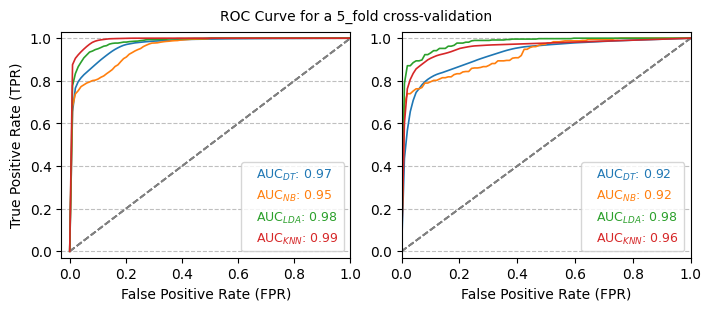

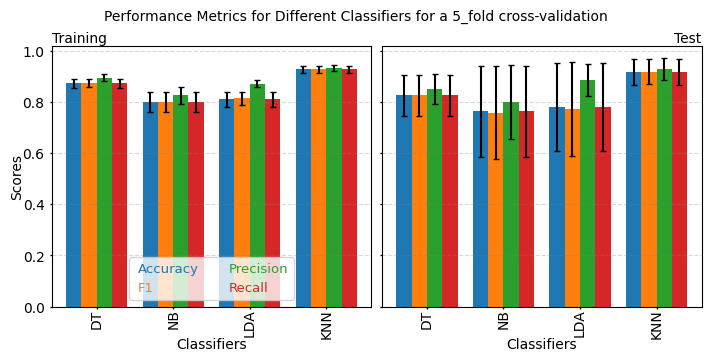

In [57]:
k_fold = 5
max_iter = 1000                                  # Max_iter for LR
solver_LR = 'lbfgs'                              # Solver for LR lbfgs, liblinear, newton-cg, newton-cholesky, sag, saga; for 
solver_LDA = "svd"                               # svd, lsqr, eigen
n_estimators = 300                               # N_estimators for RF, AdaBoost, XGBoost
max_depth = 3                                    # Max_depth for DT, RF, XGBoost
hidden_layer_MLP = (10, 10)
lr_MLP = 0.05
lr_AdaBoost = 0.1
lr_XGBoost = 0.1
kernel_SVM ="rbf"                                # 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'
C_SVM = 10

criterion = "gini"                               # gini, entropy, log_loss for DT and RF

method = "MinMaxScaler"                          # MinMaxScaler" , StandardScaler for data normalization 
normalize_active = "on"                          # normalize_active for data normalization

display_fold_classification = 2                  # Plot train and test data in k_fold eg., 1
display_classification = "off"                   # Display train and test data in k_fold eg., 1
display_normalize_classification ="off"          # Display train and test data is normalized

display_Roc_classes = "off"                      # Display Roc curve for all classes in each k-fold
display_all_kfold = "off"                        # Display Roc curve for each k-fold only
display_Roc_classification = "on"                # Display the average Roc curve of all k-folds for each classification

display_optimal_k = "off"                        # Display k optimal neighbors for KNN


fig_size_Roc = (7, 3)
fig_size_classification = (5, 3)
fig_size_performance = (7, 3.5) 
LR = "of"
MLP = "of"
SVM = "of"
DT = "on"
NB = "on"
RF = "of"
AdaBoost = "of"
XGBoost = "of"
LDA = "on"
KNN = "on"
classification_methods1(features, labels, k_fold, max_iter, solver_LR, hidden_layer_MLP, lr_MLP, kernel_SVM, C_SVM, 
                       criterion, lr_AdaBoost, lr_XGBoost, n_estimators, max_depth, solver_LDA, LR, MLP, SVM, DT,
                       NB, RF, AdaBoost, XGBoost, LDA, KNN,                          
normalize_active, method, display_fold_classification, display_classification, display_normalize_classification,
display_Roc_classes, display_all_kfold, display_Roc_classification, fig_size_Roc, fig_size_classification,
fig_size_performance, display_optimal_k)

In [56]:
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn import model_selection, metrics, neural_network, tree, naive_bayes, discriminant_analysis, neighbors, preprocessing, svm
# ============================================== Classification methods ================================================== 
def classification_methods1(data, labels, k_fold, max_iter, solver_LR, hidden_layer_MLP, lr_MLP, kernel_SVM, C_SVM, criterion, lr_AdaBoost, lr_XGBoost,
                           n_estimators, max_depth, solver_LDA, LR, MLP, SVM, DT, NB, RF, AdaBoost, XGBoost, LDA, KNN,
                           normalize_active, method, display_fold_classification, display_classification, display_normalize_classification, display_Roc_classes, display_all_kfold, display_Roc_classification, fig_size_Roc, fig_size_classification, fig_size_performance, display_optimal_k):
                           
   accuracy_tr, accuracy_te, f1_tr, f1_te, precision_tr, precision_te = [], [], [], [], [], []
   recall_tr, recall_te, type_method = [], [], []
   
   if display_Roc_classification == "on":
      fig, axs = plt.subplots(nrows=1, ncols=2, figsize=fig_size_Roc, constrained_layout=True)
   else:
      fig, axs = [], []
   # ------------------------------------------------------ Logistic Regression -------------------------------------------------------
   if LR == "on":
      model = linear_model.LogisticRegression(C=1, max_iter=max_iter, solver=solver_LR, penalty='l2', multi_class="multinomial", verbose=0)
      
      output = classification1(model, data, labels, fig, axs, k_fold, normalize_active, method, display_fold_classification, display_classification, display_normalize_classification, display_Roc_classes, display_all_kfold, display_Roc_classification, fig_size_Roc, fig_size_classification, display_optimal_k, type_class="LR")

      accuracy_tr.append(output[0]), accuracy_te.append(output[1]), f1_tr.append(output[2]), f1_te.append(output[3]), 
      precision_tr.append(output[4]), precision_te.append(output[5]), recall_tr.append(output[6]), recall_te.append(output[7]),
      type_method.append(output[8]),
   # ----------------------------------------------------------- MLP ------------------------------------------------------------------
   if MLP == "on":
      model = neural_network.MLPClassifier(hidden_layer_sizes=hidden_layer_MLP, max_iter=500, alpha=1e-4, learning_rate='invscaling', solver='adam',
                                       random_state=1, learning_rate_init=lr_MLP, verbose=False , tol=1e-4)    

      output = classification1(model, data, labels, fig, axs, k_fold, normalize_active, method, display_fold_classification, display_classification, display_normalize_classification, display_Roc_classes, display_all_kfold, display_Roc_classification, fig_size_Roc, fig_size_classification, display_optimal_k, type_class="MLP")

      accuracy_tr.append(output[0]), accuracy_te.append(output[1]), f1_tr.append(output[2]), f1_te.append(output[3]), 
      precision_tr.append(output[4]), precision_te.append(output[5]), recall_tr.append(output[6]), recall_te.append(output[7]),
      type_method.append(output[8]),
   # ------------------------------------------------------------- SVM ----------------------------------------------------------------
   if SVM == "on":
      model = svm.SVC(kernel=kernel_SVM, random_state=0, C=C_SVM, gamma="auto", probability=True) 
     
      output = classification1(model, data, labels, fig, axs, k_fold, normalize_active, method, display_fold_classification, display_classification, display_normalize_classification, display_Roc_classes, display_all_kfold, display_Roc_classification, fig_size_Roc, fig_size_classification, display_optimal_k, type_class="SVM")

      accuracy_tr.append(output[0]), accuracy_te.append(output[1]), f1_tr.append(output[2]), f1_te.append(output[3]), 
      precision_tr.append(output[4]), precision_te.append(output[5]), recall_tr.append(output[6]), recall_te.append(output[7]),
      type_method.append(output[8]),
   # -------------------------------------------------------------- DT ------------------------------------------------------------------
   if DT == "on":
      model = tree.DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, random_state=0)

      output = classification1(model, data, labels, fig, axs, k_fold, normalize_active, method, display_fold_classification, display_classification, display_normalize_classification, display_Roc_classes, display_all_kfold, display_Roc_classification, fig_size_Roc, fig_size_classification, display_optimal_k, type_class="DT")

      accuracy_tr.append(output[0]), accuracy_te.append(output[1]), f1_tr.append(output[2]), f1_te.append(output[3]), 
      precision_tr.append(output[4]), precision_te.append(output[5]), recall_tr.append(output[6]), recall_te.append(output[7]),
      type_method.append(output[8])
   # -------------------------------------------------------------- NB ------------------------------------------------------------------
   if NB == "on":
      model = naive_bayes.GaussianNB()

      output = classification1(model, data, labels, fig, axs, k_fold, normalize_active, method, display_fold_classification, display_classification, display_normalize_classification, display_Roc_classes, display_all_kfold, display_Roc_classification, fig_size_Roc, fig_size_classification, display_optimal_k, type_class="NB")

      accuracy_tr.append(output[0]), accuracy_te.append(output[1]), f1_tr.append(output[2]), f1_te.append(output[3]), 
      precision_tr.append(output[4]), precision_te.append(output[5]), recall_tr.append(output[6]), recall_te.append(output[7]),
      type_method.append(output[8])
   # -------------------------------------------------------------- RF ------------------------------------------------------------------
   if RF == "on":
      model = ensemble.RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, criterion="gini", random_state=0)

      output = classification1(model, data, labels, fig, axs, k_fold, normalize_active, method, display_fold_classification, display_classification, display_normalize_classification, display_Roc_classes, display_all_kfold, display_Roc_classification, fig_size_Roc, fig_size_classification, display_optimal_k, type_class="RF")

      accuracy_tr.append(output[0]), accuracy_te.append(output[1]), f1_tr.append(output[2]), f1_te.append(output[3]), 
      precision_tr.append(output[4]), precision_te.append(output[5]), recall_tr.append(output[6]), recall_te.append(output[7]),
      type_method.append(output[8])
   # ----------------------------------------------------------- AdaBoost ---------------------------------------------------------------
   if AdaBoost == "on":
      #  # model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
      # # model = ensemble.AdaBoostClassifier(base_estimator=model, n_estimators=100, random_state=0)
      model = ensemble.AdaBoostClassifier(n_estimators=n_estimators, learning_rate=lr_AdaBoost, random_state=0)

      output = classification1(model, data, labels, fig, axs, k_fold, normalize_active, method, display_fold_classification, display_classification, display_normalize_classification, display_Roc_classes, display_all_kfold, display_Roc_classification, fig_size_Roc, fig_size_classification, display_optimal_k, type_class="AdaBoost")

      accuracy_tr.append(output[0]), accuracy_te.append(output[1]), f1_tr.append(output[2]), f1_te.append(output[3]), 
      precision_tr.append(output[4]), precision_te.append(output[5]), recall_tr.append(output[6]), recall_te.append(output[7]),
      type_method.append(output[8])
   # ------------------------------------------------------------ XGBoost ---------------------------------------------------------------
   if XGBoost == "on":
      model = XGBClassifier(max_depth=5, n_estimators=n_estimators, learning_rate=lr_XGBoost, random_state=0, objective='multi:softpr_teob')

      output = classification1(model, data, labels, fig, axs, k_fold, normalize_active, method, display_fold_classification, display_classification, display_normalize_classification, display_Roc_classes, display_all_kfold, display_Roc_classification, fig_size_Roc, fig_size_classification, display_optimal_k, type_class="XGBoost")

      accuracy_tr.append(output[0]), accuracy_te.append(output[1]), f1_tr.append(output[2]), f1_te.append(output[3]), 
      precision_tr.append(output[4]), precision_te.append(output[5]), recall_tr.append(output[6]), recall_te.append(output[7]),
      type_method.append(output[8])
   # -------------------------------------------------------------- LDA -----------------------------------------------------------------
   if LDA == "on":
      model = discriminant_analysis.LinearDiscriminantAnalysis(n_components=len(np.unique(labels)) - 1, solver=solver_LDA)

      output = classification1(model, data, labels, fig, axs, k_fold, normalize_active, method, display_fold_classification, display_classification, display_normalize_classification, display_Roc_classes, display_all_kfold, display_Roc_classification, fig_size_Roc,fig_size_classification, display_optimal_k, type_class="LDA")

      accuracy_tr.append(output[0]), accuracy_te.append(output[1]), f1_tr.append(output[2]), f1_te.append(output[3]), 
      precision_tr.append(output[4]), precision_te.append(output[5]), recall_tr.append(output[6]), recall_te.append(output[7]),
      type_method.append(output[8])
   # -------------------------------------------------------------- KNN -----------------------------------------------------------------
   if KNN == "on":
      model = []

      output = classification1(model, data, labels, fig, axs, k_fold, normalize_active, method, display_fold_classification, display_classification, display_normalize_classification, display_Roc_classes, display_all_kfold, display_Roc_classification, fig_size_Roc, fig_size_classification, display_optimal_k, type_class="KNN")

      accuracy_tr.append(output[0]), accuracy_te.append(output[1]), f1_tr.append(output[2]), f1_te.append(output[3]), 
      precision_tr.append(output[4]), precision_te.append(output[5]), recall_tr.append(output[6]), recall_te.append(output[7]),
      type_method.append(output[8]),

   performance(accuracy_tr, accuracy_te, precision_tr, precision_te, f1_tr, f1_te, recall_tr, recall_te, type_method, k_fold, fig_size_performance)
   

In [52]:
# ================================================== classification ====================================================== 
def classification1(model, data, labels, fig, axs, k_fold=5, normalize_active="off", method="MinMaxScaler",  
                   display_fold_classification=1, display_classification="off", display_normalize_classification="off",
                   display_Roc_classes="off", display_all_kfold="off", display_Roc_classification="off",fig_size_Roc=(5, 3), 
                   
                   fig_size_classification=(5, 3), display_optimal_k="off", type_class="LR"):
   # -------------------------------------------------------- K_fold --------------------------------------------------------------
   cv = model_selection.StratifiedKFold(n_splits=k_fold)     
   # -------------------------------------------------------- Parameters ----------------------------------------------------------
   tpr_tr = np.zeros((100, k_fold))
   tpr_te = np.zeros((100, k_fold))
   auc_tr = np.zeros(k_fold)
   auc_te = np.zeros(k_fold)
   accuracy_tr, accuracy_te, f1_tr, f1_te, precision_tr, precision_te, recall_tr, recall_te = [], [], [], [], [], [],[], []
   
   for j, (train, test) in enumerate(cv.split(data, labels)):  
      # --------------------------------------------------- Split data ------------------------------------------------------------
      data_train = data[train] 
      data_test = data[test]
      label_train = labels[train]
      label_test = labels[test]
      # -------------------------------------------------- Data normalization -----------------------------------------------------
      if normalize_active == "on": 
          data_train, data_test = data_normalization(data_train, data_test, method=method)   # method 1: MinMaxScaler, method 2: StandardScaler
      # ------------------------------------------------------ KNN methods --------------------------------------------------------
      if type_class == "KNN":
            num_k = Knn_optimal.knn_optimal(data_train, label_train, data_test, label_test, display_optimal_k, 
                                            n=21, fig_size=(3.5,2.5))  # Obtain optimal K
            model = neighbors.KNeighborsClassifier(n_neighbors=num_k, weights='uniform', metric='minkowski')
      # ---------------------------------------------------- Training Network -----------------------------------------------------
      model.fit(data_train, label_train)                                           # Fit i.e., Training
      # ---------------------------------------------- Training Section -----------------------------------------------------------
      label_predict_train = model.predict(data_train)
      accuracy_tr.append(metrics.accuracy_score(label_train, label_predict_train)) # Calculate accuracy  
      f1_tr.append(metrics.f1_score(label_train, label_predict_train, average='weighted')) # Calculate F1 score
      precision_tr.append(metrics.precision_score(label_train, label_predict_train, average='weighted'))  # Calculate precision
      recall_tr.append(metrics.recall_score(label_train, label_predict_train, average='weighted'))   # Calculate recall
      # ----------------------------------------------- Test Section --------------------------------------------------------------
      label_predict_test = model.predict(data_test)
      accuracy_te.append(metrics.accuracy_score(label_test, label_predict_test)) # Calculate accuracy  
      f1_te.append(metrics.f1_score(label_test, label_predict_test, average='weighted')) # Calculate F1 score
      precision_te.append(metrics.precision_score(label_test, label_predict_test, average='weighted'))  # Calculate precision
      recall_te.append(metrics.recall_score(label_test, label_predict_test, average='weighted'))   # Calculate recall
      # cr_test = metrics.classification_report(label_test, label_predict_test, labels=np.unique(label_test))
      # --------------------------------------------- Compute ROC curve and area the curve ----------------------------------------
      tpr_tr[:, j], tpr_te[:, j], auc_tr[j], auc_te[j] = roc_curve(model, data_train, data_test, label_train, label_test, j, type_class,display_Roc_classes, fig_size_Roc)
      
      if display_fold_classification == j:
          plot_classification(data_train, label_train, data_test, label_test, model, j, type_class, display_classification, display_normalize_classification, fig_size_classification)

   roc_curve_all_kfold(tpr_tr, tpr_te, auc_tr, auc_te, fig, axs, k_fold, type_class, display_all_kfold, display_Roc_classification, fig_size_Roc)
   
   return accuracy_tr, accuracy_te, f1_tr, f1_te, precision_tr, precision_te, recall_tr, recall_te, type_class
